In [1]:
import pickle as pk
import numpy as np
from normalization import *
import torch
from dataloader import combine_sparse_tensors
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

/home/yangxiaojie/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.metrics.pairwise import cosine_similarity 

In [4]:
interval = 4
reg_num = 490
treat_dim = 10
tim_num = 24
input_window = 24
output_window = 24
training_rate = 0.8
validate_rate = 0.1
test_rate = 0.1
causal = True

In [5]:
import pandas as pd
import pickle as pk
regions = pd.read_csv('/home/yangxiaojie/KDD2025/poi/FEA_hyoujun.csv')

def nan_to_empty_str(value):
    if pd.isna(value):
        return ''
    return str(value)

code2region = dict()
for i, row in regions.iterrows():
    code2region[str(row['標準地域コード']).zfill(5)] = row['都道府県'] + nan_to_empty_str(row['政令市･郡･支庁･振興局等']) + nan_to_empty_str(row['市区町村'])

region2code = dict(zip(list(code2region.values()), list(code2region.keys())))


with open('/home/yangxiaojie/KDD2025/selected_mesh.pk', 'rb') as f:
    selected_mesh = pk.load(f)

assert len(set(selected_mesh.values())) == reg_num

idx2code = dict(zip(list(range(reg_num)), sorted(set(selected_mesh.values()))))

code2idx = dict(zip(idx2code.values(),idx2code.keys()))

In [6]:
def data_scaler(data):
    data = torch.FloatTensor(data)
    scaler = StandardScaler(mean = data.mean(dim = 0), std = data.std(dim = 0))
    return scaler

In [171]:
with open('/home/yangxiaojie/KDD2025/model/data/odmetrics_sparse_tensors.pk', 'rb') as f:
    adjacency_matrix = pk.load(f)

In [172]:
flows = np.load('/home/yangxiaojie/KDD2025/model/data/flows.npy')
flows = flows[:, ::interval, :]
flows = flows.reshape(len(adjacency_matrix), reg_num)

In [173]:
# treatment_path = '/home/yangxiaojie/KDD2025/samples・説明書/treatment_scores_0618.pk'
# with open(treatment_path, 'rb') as f:
#     treatments = pk.load(f)
prev_path = '/home/yangxiaojie/KDD2025/samples・説明書/prev_treats_mean.npy'
post_path = '/home/yangxiaojie/KDD2025/samples・説明書/post_treats_mean.npy'

prev_treats = np.load(prev_path)
post_treats = np.load(post_path)
prev_treats, post_treats = torch.FloatTensor(prev_treats), torch.FloatTensor(post_treats)

In [174]:
# treat_dict = {}
# alltreat = []

# alltreat = np.zeros((len(adjacency_matrix), reg_num, treat_dim))
# alltreat[:, :, 3] = 100

# for d in treatments:
#     for t in treatments[d]:
#         treat_dict[d * tim_num + t] = {}
#         for c in treatments[d][t]:
#             treat = np.mean([_ for _ in treatments[d][t][c] if len(_) == treat_dim], axis = 0)

#             if np.isnan(treat).any():
#                 treat = np.array([0, 0, 0, 100, 0, 0, 0, 0, 0, 0])
#             alltreat[d * tim_num + t, c] = treat
# alltreat[:, :, 3] = 100 - alltreat[:, :, 3]

In [175]:
# treat_max = np.max(alltreat, axis=(0, 1), keepdims=True)

# treat_min = np.min(alltreat, axis=(0, 1), keepdims=True)

# alltreat = (alltreat - treat_min) / (treat_max - treat_min)

In [176]:
indices = []
for i in range(flows.shape[0]- input_window - output_window):
    indices.append(list(range(i, i + input_window + output_window)))

In [177]:
class StandardScaler(Scaler):
    """
    Z-score归一化
    x = (x - x.mean) / x.std
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean

In [178]:
length = len(indices)
train_len = int(length * training_rate)
valid_len = int(length * validate_rate)
train_uplimit = indices[train_len][-1]
scaler = data_scaler(flows[:train_uplimit, :])

In [179]:
scaler = StandardScaler(mean = flows[:train_uplimit, :].mean(axis = 0), std = flows[:train_uplimit, :].std(axis = 0))

In [180]:
data = []
for index, indice in enumerate(tqdm(indices, desc="Processing")):
    x = scaler.transform(torch.FloatTensor(flows[indice[:input_window], :]))

    y = scaler.transform(torch.FloatTensor(flows[indice[input_window:], :]))
    if causal:
        prev_treat = prev_treats[indice[:input_window]]
        post_treat = post_treats[indice[input_window:]]
        treats = torch.cat([prev_treat, post_treat], dim = 0)
    else:
        treats = None

    adj = combine_sparse_tensors(adjacency_matrix[indice[0] : indice[input_window]])
    indice = torch.LongTensor(indice)
    t = indice[:input_window] % tim_num  # 获取时间步
    t = t.unsqueeze(1).expand(-1, x.shape[1])  # 扩展时间步的维度

    data.append([indice, x, y, t, treats, adj])

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8736/8736 [04:53<00:00, 29.77it/s]


In [17]:
def calculate_hour(hours_passed, start_date = '2023-04-01'):
    # 将起始日期转换为 datetime 对象
    start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
    
    # 计算目标日期时间
    target_datetime = start_datetime + timedelta(hours=hours_passed)
    
    # 检查是否为周末
    is_weekend = target_datetime.weekday() >= 5  # 5 是周六，6 是周日
    
    # 计算目标小时（0-23 或 24-47）
    if is_weekend:
        result_hour = target_datetime.hour + 24
    else:
        result_hour = target_datetime.hour
    
    return result_hour

def calculate_week_hour(hours_passed, start_date = '2023-04-01'):
    # 将起始日期转换为 datetime 对象
    start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
    
    # 计算目标日期时间
    target_datetime = start_datetime + timedelta(hours=hours_passed)
    
    # 计算从周开始的小时数（0-143）
    #days_since_week_start = target_datetime.weekday() # 星期一为0
    result_hour = target_datetime.weekday() * 24 + target_datetime.hour
    
    return result_hour

def combine_sparse_tensors(tensor_list):
    batch_size = len(tensor_list)
    V = tensor_list[0].size(0)
    
    combined_indices = []
    combined_values = []

    # 遍历列表中的每个稀疏张量
    for i, tensor in enumerate(tensor_list):
        indices = tensor._indices()
        values = tensor._values()
        
        # 添加批次维度信息
        batch_indices = torch.cat([torch.full((1, indices.size(1)), i, dtype=torch.long), indices], dim=0)
        
        # 将当前张量的 indices 和 values 添加到组合列表中
        if len(combined_indices) == 0:
            combined_indices = batch_indices
            combined_values = values
        else:
            combined_indices = torch.cat((combined_indices, batch_indices), dim=1)
            combined_values = torch.cat((combined_values, values))

    # 新的张量大小
    size = torch.Size([batch_size, V, V])

    # 创建合并后的稀疏张量
    combined_tensor = torch.sparse_coo_tensor(combined_indices, combined_values, size=size)
    
    return combined_tensor

In [18]:
start_date = '2023-04-01'
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')

In [19]:
device = 'cuda:0'
causal_model = torch.load('/home/yangxiaojie/KDD2025/model/models/model_5119_1111_True.pth').to(device)

In [20]:
# import pandas as pd
# start_date = '2023-04-01 00:00:00'
# target_time = '2023-07-28 00:00:00'
# target_region = '東京都墨田区'
# region_idx = code2idx[region2code[target_region]]

# # 将日期字符串转换为 datetime 对象
# start_date = pd.to_datetime(start_date)
# target_time = pd.to_datetime(target_time)

# # 计算时间差
# time_difference = target_time - start_date

# # 将时间差转换为小时数
# time_idx = int(time_difference.total_seconds() / 3600)
# print(region_idx)
# print(time_idx)

# device = 'cuda:3'
# indice, x, y, _, treat, adj = data[time_idx]
# mask = None

# causal_model.eval()

# indice = torch.LongTensor(indice)
# t = torch.LongTensor([calculate_week_hour(i.numpy().tolist()) for i in indice[:input_window]])
# #t = indice[:self.args.input_window] % self.args.tim_num  # 获取时间步
# t = t.unsqueeze(1).expand(-1, x.shape[1])  # 扩展时间步的维度

# x = x.unsqueeze(0).unsqueeze(-1).to(device)
# y = y.unsqueeze(0).to(device)
# t = t.unsqueeze(0).to(device)
# adj = adj.unsqueeze(0).to(device)
# treat = torch.FloatTensor(treat).unsqueeze(0).to(device)
# #treat = torch.zeros_like(treat)
# y = y.permute(0, 2, 1)
# y_pre, w, z, encode_treat = causal_model(x, t, treat, adj, mask)
# y_pre = y_pre.unsqueeze(-1).reshape(y.shape)

# preds = []
# trues = []
# for i in range(output_window):  
#     y_pred = torch.flatten(scaler.inverse_transform(y_pre[:, :, i].detach().cpu().squeeze())).detach().numpy().tolist()
#     y_true = torch.flatten(scaler.inverse_transform(y[:, :, i].detach().cpu().squeeze())).detach().numpy().tolist()
#     preds.append(y_pred[region_idx])
#     trues.append(y_true[region_idx])

# plt.figure(figsize=(10, 6))
# plt.plot(preds, label='Predictions', color='g')
# plt.plot(trues, label='Ground Truth', color='r')
# plt.xlabel('Time')
# plt.ylabel('Values')
# plt.title('Predictions vs True Values')
# plt.legend()
# plt.show()

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt

# weights = w.detach().cpu().numpy()
# mmax = weights.max(axis = 0, keepdims = True)
# mmin = weights.min(axis = 0, keepdims = True)
# weights_norm = (weights -  mmin) / (mmax - mmin)

# # 使用 matplotlib 的 imshow 绘制热力图
# plt.figure(figsize=(12, 8))
# plt.imshow(weights / 490, aspect='auto', cmap='viridis')
# plt.colorbar()
# plt.title('Weight Heatmap')
# plt.xlabel('Time Steps')
# plt.ylabel('Samples')
# plt.show()

In [182]:
causal_model.eval()
alltreats = {}
with torch.no_grad():
    for i in range(len(data)):
        print(i, end = '\r')
        indice, x, y, t, treat, adj = data[i]

        indice = torch.LongTensor(indice)
        t = torch.LongTensor([calculate_week_hour(i.numpy().tolist()) for i in indice[:input_window]])
        #t = indice[:self.args.input_window] % self.args.tim_num  # 获取时间步
        t = t.unsqueeze(1).expand(-1, x.shape[1])  # 扩展时间步的维度

        x = x.unsqueeze(0).unsqueeze(-1).to(device).float()
        y = y.unsqueeze(0).to(device)
        t = t.unsqueeze(0).to(device)
        adj = adj.unsqueeze(0).to(device)
        treat = torch.FloatTensor(treat).unsqueeze(0).to(device)
        y = y.permute(0, 2, 1)
        y_pre, w, z, treat_encode = causal_model(x, t, treat, adj)
        y_pre = y_pre.unsqueeze(-1).reshape(y.shape)

        treat_base = causal_model.get_treat_base().detach().cpu().numpy()
        treat_encode = treat_encode.detach().cpu().numpy()
        cosine_sim = cosine_similarity(treat_encode, treat_base)

        alltreats[i] = [indice, treat.cpu(), treat_encode, cosine_sim]

In [23]:
# start_date = '2023-04-01 00:00:00'
# target_time = '2024-01-01 17:00:00'

# # 将日期字符串转换为 datetime 对象
# start_date = pd.to_datetime(start_date)
# target_time = pd.to_datetime(target_time)

# # 计算时间差
# time_difference = target_time - start_date

# # 将时间差转换为小时数
# time_idx = int(time_difference.total_seconds() / 3600)
# print(time_idx)

In [26]:
start_date = '2023-04-01 00:00:00'
target_time = '2024-01-01 12:00:00'
target_region = '石川県金沢市'
region_idx = code2idx[region2code[target_region]]

# 将日期字符串转换为 datetime 对象
start_date = pd.to_datetime(start_date)
target_time = pd.to_datetime(target_time)

# 计算时间差
time_difference = target_time - start_date

# 将时间差转换为小时数
time_idx = int(time_difference.total_seconds() / 3600)
print(time_idx, region_idx)

#print(treat[0, :, region_idx, :])

indice, case_treat, treat_encode, cosine_sim = treats[time_idx]

print(case_treat[:, :, region_idx, :])

X_example = treat_encode[region_idx, :].reshape(1, 64)

6612 239
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [-0.8000,  0.2000,  0.0000,  0.7000,  0.5000,  0.6000,  0.9000,
           0.7000,  0.4000,  0.6000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [-0.7900,  0.0467,  0.0000,  0.7733,  0.4033,  0.5900,  0.8233,
           0.6333,  0.3633,  0.4700],
         [-0.8000,  0.0571,  0.0000,  0.7429,  0.3000,  0.5286,  0.8143,
           0.5429,  0.2571,  0.4429],
         [-0.8000,  0.0125,  0.0000,  0.7875,  0.3875,  0.6812,  0.8313,
           0.5938,  0.3313,  0.4625],
         [-0.7800,  0.0000,  0.0000,  0.7800,  0.4000,  0.6400,  0.8800,
           0.5800,  0.3400,  0.4600],
         [-0.8000,  0.0500,  0.0000,  0.7750,  0.2500,  0.5500,  0.8500,
           0.6000,  0.2000,  0

In [29]:
start_date = '2023-04-01 00:00:00'
target_time = '2024-03-01 00:00:00'

# 将日期字符串转换为 datetime 对象
start_date = pd.to_datetime(start_date)
target_time = pd.to_datetime(target_time)

# 计算时间差
time_difference = target_time - start_date
time_idx = int(time_difference.total_seconds() / 3600)

# 将时间差转换为小时数
y_pred = []
y_true = []

    
idx = time_idx

device = 'cuda:0'
indice, x, y, _, _, adj = data[idx]

causal_model.eval()

with torch.no_grad():
    indice = torch.LongTensor(indice)
    t = torch.LongTensor([calculate_week_hour(i.numpy().tolist()) for i in indice[:input_window]])
    #t = indice[:self.args.input_window] % self.args.tim_num  # 获取时间步
    t = t.unsqueeze(1).expand(-1, x.shape[1])  # 扩展时间步的维度

    x = x.unsqueeze(0).unsqueeze(-1).to(device).float()
    y = y.unsqueeze(0).to(device)
    t = t.unsqueeze(0).to(device)
    adj = adj.unsqueeze(0).to(device)

    treat = case_treat[:, :, region_idx, :].unsqueeze(2).repeat(1, 1, 490, 1).to(device)

    y_pre, _, _, _ = causal_model(x, t, treat, adj,)
    for j in range(output_window):  
#             y_pred.append(torch.flatten(scaler.inverse_transform(y_pre[:, j].detach().cpu().unsqueeze(0))).detach().numpy())
#             y_true.append(torch.flatten(scaler.inverse_transform(y[:, j].detach().cpu().squeeze())).detach().numpy())
#         y_pred.append(torch.flatten(y_pre[:, j].detach().cpu().unsqueeze(0)).detach().numpy())
#         y_true.append(torch.flatten(y[:, j].detach().cpu().squeeze()).detach().numpy())
        y_pred = torch.flatten(y_pre[:, j].detach().cpu().unsqueeze(0)).detach().numpy()
        y_true = torch.flatten(y[:, j].detach().cpu().squeeze()).detach().numpy()

y_pred = np.array(y_pred)
y_true = np.array(y_true)

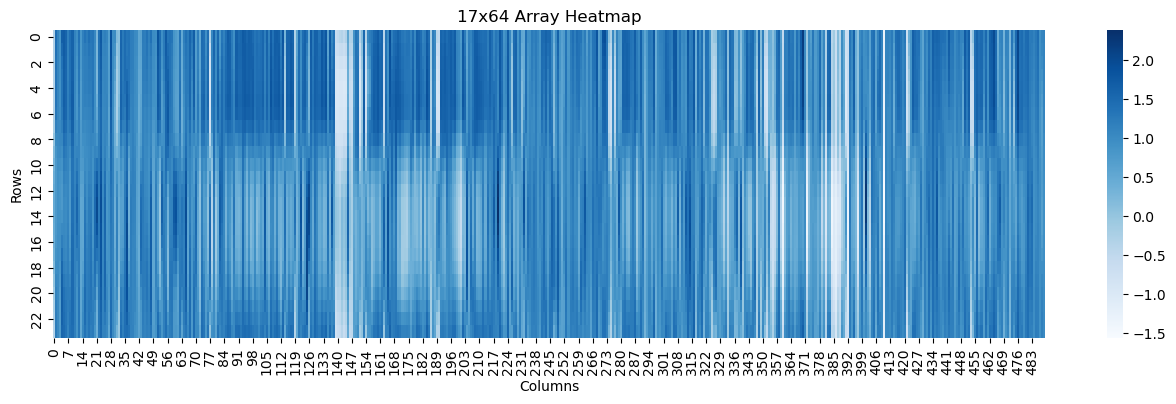

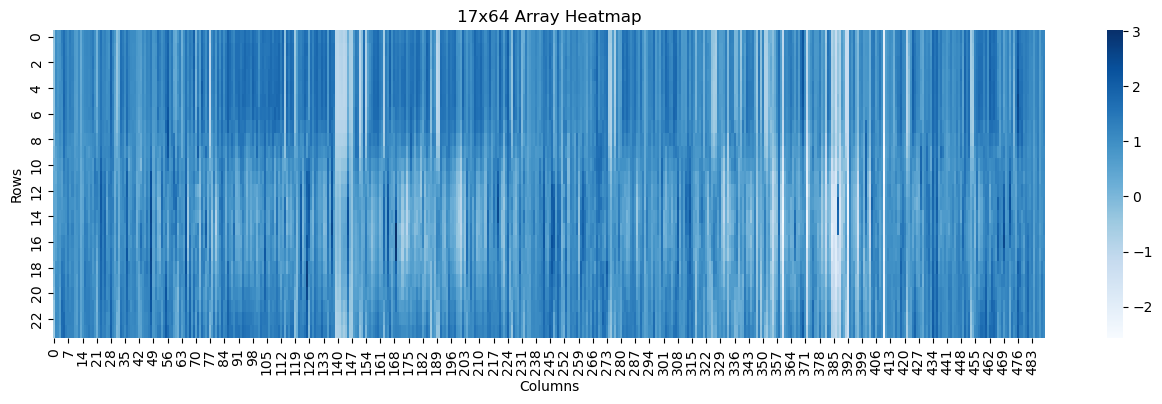

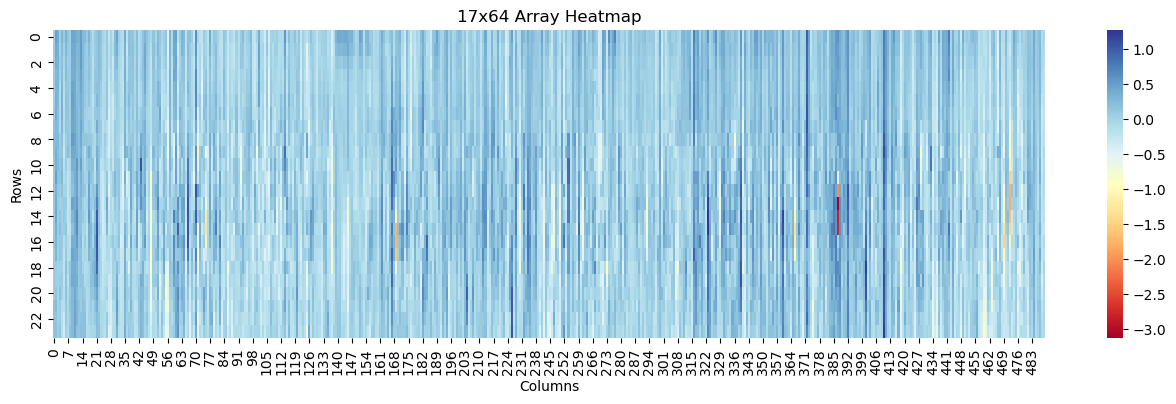

In [31]:
# 使用 Seaborn 绘制热图
y_pred = y_pre.cpu().permute(1, 0)
plt.figure(figsize=(16, 4))
sns.heatmap(y_pred, annot=False, cmap='Blues')
plt.title('17x64 Array Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# 使用 Seaborn 绘制热图
y_true = y.squeeze().permute(1, 0).cpu().permute(1, 0)
plt.figure(figsize=(16, 4))
sns.heatmap(y_true, annot=False, cmap='Blues')
plt.title('17x64 Array Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# 使用 Seaborn 绘制热图
y_diff = y_pred - y_true
plt.figure(figsize=(16, 4))
sns.heatmap(y_diff, annot=False, cmap='RdYlBu')
plt.title('17x64 Array Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [32]:
start_date = '2023-04-01 00:00:00'
target_time = '2023-08-02 08:00:00'
target_region = '沖縄県那覇市'
region_idx = code2idx[region2code[target_region]]

# 将日期字符串转换为 datetime 对象
start_date = pd.to_datetime(start_date)
target_time = pd.to_datetime(target_time)

# 计算时间差
time_difference = target_time - start_date

# 将时间差转换为小时数
time_idx = int(time_difference.total_seconds() / 3600)
print(time_idx, region_idx)

indice, case_treat, treat_encode, cosine_sim = treats[time_idx]

print(case_treat[0, :, region_idx, :])

X_example2 = treat_encode[region_idx, :].reshape(1, 64)

2960 488
tensor([[-0.8000,  0.2000,  0.0000,  0.7000,  0.4000,  0.6000,  0.8000,  0.8000,
          0.4000,  0.5000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 

In [34]:
start_date = '2023-04-01 00:00:00'
target_time = '2023-12-24 12:00:00'
target_region = '千葉県船橋市'
region_idx = code2idx[region2code[target_region]]

# 将日期字符串转换为 datetime 对象
start_date = pd.to_datetime(start_date)
target_time = pd.to_datetime(target_time)

# 计算时间差
time_difference = target_time - start_date

# 将时间差转换为小时数
time_idx = int(time_difference.total_seconds() / 3600)
print(time_idx, region_idx)

indice, case_treat, treat_encode, cosine_sim = treats[time_idx]

print(case_treat[0, :, region_idx, :])

X_example2 = treat_encode[region_idx, :].reshape(1, 64)
print(X_example2)

6420 121
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.8000, 0.8000, 0.0000, 0.3000, 0.0000, 0.0000, 0.0000,
         0.1000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
 

In [36]:
start_date = '2023-04-01 00:00:00'
target_time = '2024-03-01 00:00:00'

# 将日期字符串转换为 datetime 对象
start_date = pd.to_datetime(start_date)
target_time = pd.to_datetime(target_time)

# 计算时间差
time_difference = target_time - start_date
time_idx = int(time_difference.total_seconds() / 3600)

# 将时间差转换为小时数
y_pred = []
y_true = []

    
idx = time_idx

device = 'cuda:0'
indice, x, y, _, _, adj = data[idx]

causal_model.eval()

with torch.no_grad():
    indice = torch.LongTensor(indice)
    t = torch.LongTensor([calculate_week_hour(i.numpy().tolist()) for i in indice[:input_window]])
    #t = indice[:self.args.input_window] % self.args.tim_num  # 获取时间步
    t = t.unsqueeze(1).expand(-1, x.shape[1])  # 扩展时间步的维度

    x = x.unsqueeze(0).unsqueeze(-1).to(device).float()
    y = y.unsqueeze(0).to(device)
    t = t.unsqueeze(0).to(device)
    adj = adj.unsqueeze(0).to(device)

    #treat = fake_treat.to(device)
    treat = case_treat[:, :, region_idx, :].unsqueeze(2).repeat(1, 1, 490, 1).to(device)

    y_pre, _, _, _ = causal_model(x, t, treat, adj)
    for j in range(output_window):  
#             y_pred.append(torch.flatten(scaler.inverse_transform(y_pre[:, j].detach().cpu().unsqueeze(0))).detach().numpy())
#             y_true.append(torch.flatten(scaler.inverse_transform(y[:, j].detach().cpu().squeeze())).detach().numpy())
#         y_pred.append(torch.flatten(y_pre[:, j].detach().cpu().unsqueeze(0)).detach().numpy())
#         y_true.append(torch.flatten(y[:, j].detach().cpu().squeeze()).detach().numpy())
        y_pred = torch.flatten(y_pre[:, j].detach().cpu().unsqueeze(0)).detach().numpy()
        y_true = torch.flatten(y[:, j].detach().cpu().squeeze()).detach().numpy()

y_pred = np.array(y_pred)
y_true = np.array(y_true)

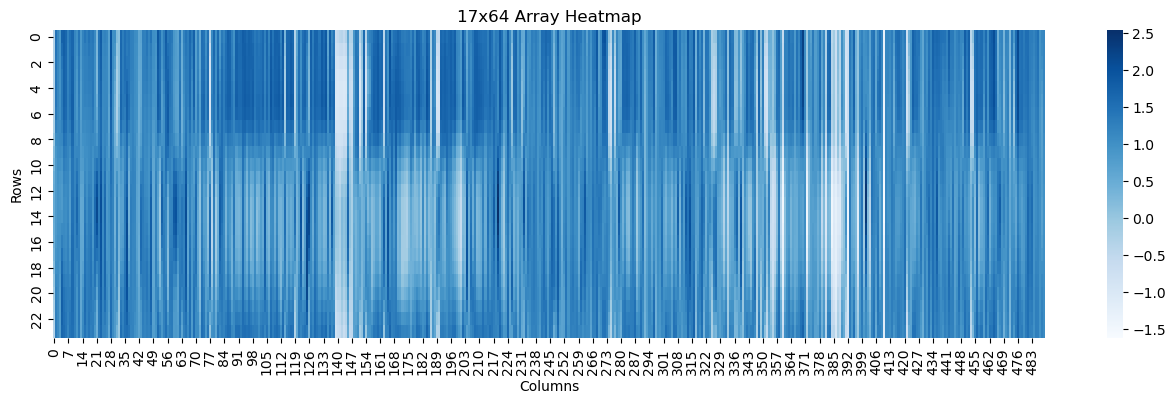

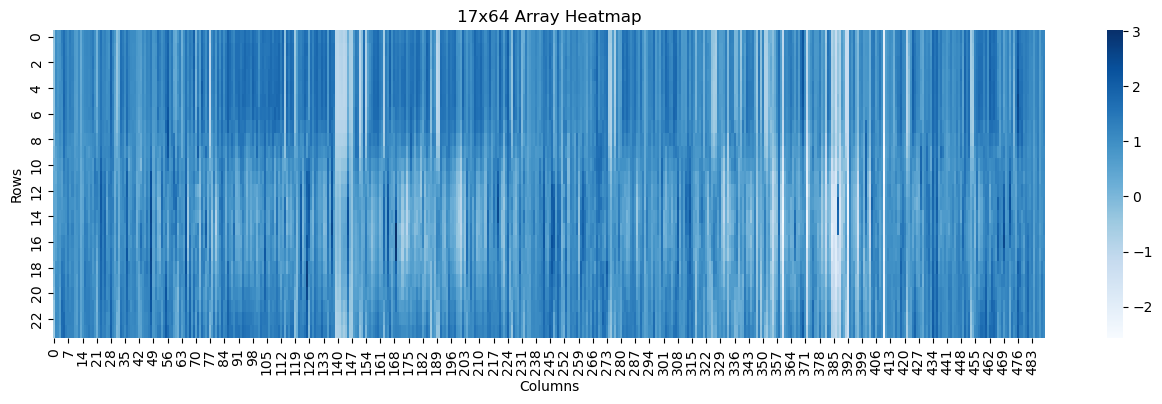

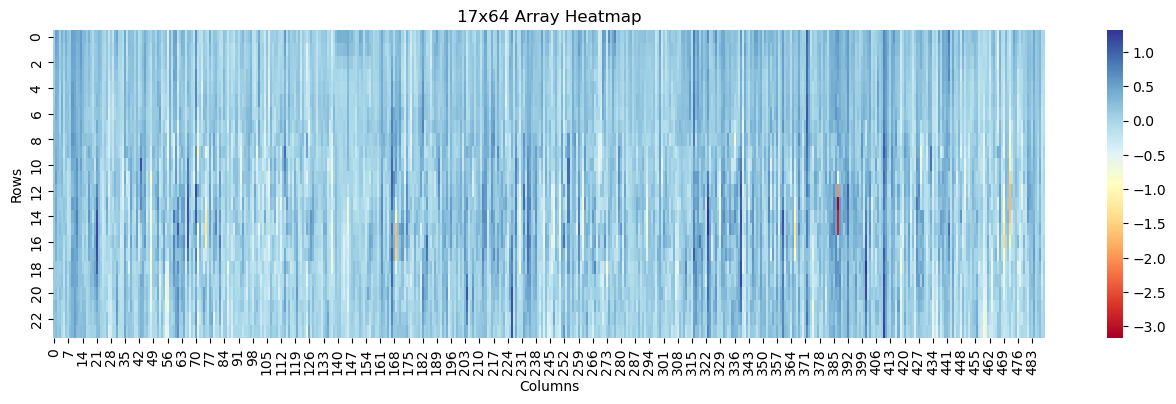

In [38]:
# 使用 Seaborn 绘制热图
y_pred = y_pre.cpu().permute(1, 0)
plt.figure(figsize=(16, 4))
sns.heatmap(y_pred, annot=False, cmap='Blues')
plt.title('17x64 Array Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# 使用 Seaborn 绘制热图
y_true = y.squeeze().permute(1, 0).cpu().permute(1, 0)
plt.figure(figsize=(16, 4))
sns.heatmap(y_true, annot=False, cmap='Blues')
plt.title('17x64 Array Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# 使用 Seaborn 绘制热图
y_diff = y_pred - y_true
plt.figure(figsize=(16, 4))
sns.heatmap(y_diff, annot=False, cmap='RdYlBu')
plt.title('17x64 Array Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [39]:
cosine_similarity(X_example2, treat_base) * 10 + 10, cosine_similarity(X_example, treat_base) * 10 + 10

(array([[13.082596]], dtype=float32), array([[9.804638]], dtype=float32))

In [40]:
cosine_similarity(X_example, treat_base)

array([[-0.01953625]], dtype=float32)

In [41]:
cosine_similarity(X_example2, treat_base)

array([[0.3082596]], dtype=float32)

In [42]:
treat_base

array([[ 0.02750693,  0.10130942,  0.00725636,  0.12571222, -0.03236773,
         0.11976451,  0.05080556,  0.18150192,  0.13901106,  0.05725557,
        -0.09189888,  0.057156  , -0.25305495, -0.0401516 ,  0.03188879,
        -0.01876927,  0.03067108, -0.03426895,  0.10278884,  0.08207361,
         0.10548052,  0.08130847,  0.14334208,  0.07338768,  0.159023  ,
        -0.0234864 ,  0.17036244,  0.14994383, -0.07694192,  0.23873916,
         0.12198655, -0.03130476, -0.15889007,  0.08059035,  0.13894087,
        -0.01002376,  0.10624143, -0.09773283,  0.15397915, -0.0415687 ,
         0.09027401,  0.01958003,  0.072771  ,  0.01960037, -0.0345551 ,
        -0.14159766, -0.16504091,  0.05612011,  0.15709862,  0.11828598,
         0.02609922,  0.06473776,  0.12907021, -0.01990844,  0.19791223,
         0.09465587,  0.11571531, -0.12155809, -0.08153395,  0.18150993,
        -0.18404913,  0.0447324 ,  0.06106786, -0.05562347]],
      dtype=float32)

In [43]:
encodedtreats = []
sims = []
#alltreats = []
for i in treats:
    print(i, end = '\r')
    indice, treat, treat_encode, cosine_sim = treats[i]
    encodedtreats += treat_encode.tolist()
    sims += cosine_sim.tolist()
    #alltreats += treat.squeeze(0).permute(1, 0, 2).cpu().numpy().tolist()

In [44]:
encodedtreats = np.array(encodedtreats)
sims = np.array(sims)

In [45]:
#alltreats = np.array(alltreats)

In [46]:
labels = np.floor(sims * 10 + 10)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [48]:
X = encodedtreats
label = labels

In [51]:
sample_size = 1000
indices = np.random.choice(range(X.shape[0]), size=sample_size, replace=False)
X_sample = X[indices]
label_sample = label[indices]

#X_sample = np.concatenate((X_sample, X_example))

X_examples = np.concatenate((X_example, X_example2), axis=0)

# 然后将 (10000, 64) 的数组和 (2, 64) 的数组拼接成 (10002, 64) 的数组
X_sample_examples = np.concatenate((X_sample, X_examples), axis=0)

# 数据标准化
datascaler = StandardScaler()
X_scaled = datascaler.fit_transform(X_sample_examples)

# PCA降维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_examples)


# # t-SNE降维
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample_examples)

/tmp/ipykernel_3219427/551421892.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[-1][0], X_pca[-1][1], edgecolor='red', cmap='viridis', s=2)
/tmp/ipykernel_3219427/551421892.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[-1][0], X_pca[-1][1], edgecolor='red', cmap='viridis', s=500, facecolors='none', linewidths=3)
/tmp/ipykernel_3219427/551421892.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[-2][0], X_pca[-2][1], edgecolor='red', cmap='viridis', s=2)
/tmp/ipykernel_3219427/551421892.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[-2][0], X_pca[-2][1], edgecolor='blue', cmap='viridis', s=500, facecolors='none', linewidths=3)
/tmp/ipykernel_3219427/551421892.py:20: UserWarning: No data for colormapping provided via '

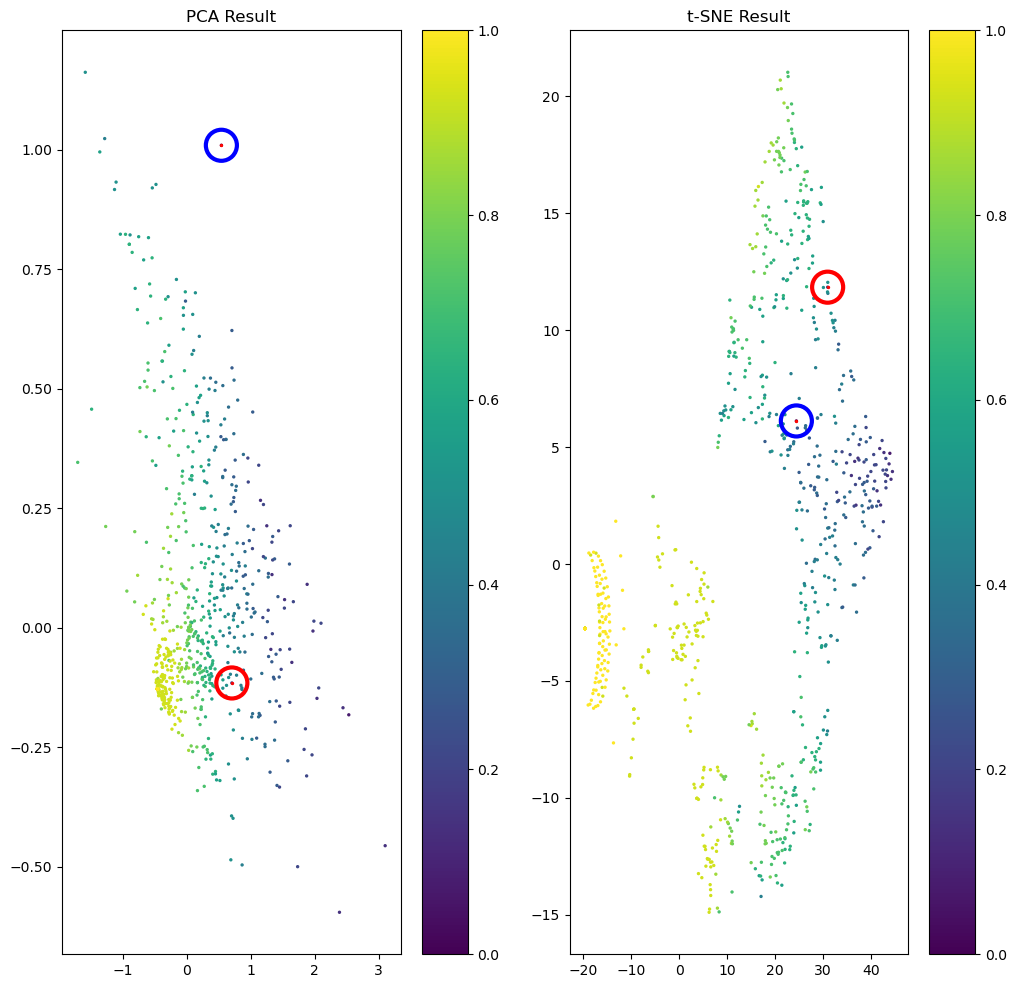

In [52]:
# 可视化PCA结果
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.concatenate((label_sample, np.array([[6], [9]])), axis=0), cmap='viridis', s=2)

plt.scatter(X_pca[-1][0], X_pca[-1][1], edgecolor='red', cmap='viridis', s=2)
plt.scatter(X_pca[-1][0], X_pca[-1][1], edgecolor='red', cmap='viridis', s=500, facecolors='none', linewidths=3)

plt.scatter(X_pca[-2][0], X_pca[-2][1], edgecolor='red', cmap='viridis', s=2)
plt.scatter(X_pca[-2][0], X_pca[-2][1], edgecolor='blue', cmap='viridis', s=500, facecolors='none', linewidths=3)


plt.colorbar()
plt.title('PCA Result')

# 可视化t-SNE结果
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.concatenate((label_sample, np.array([[6], [9]])), axis=0), cmap='viridis', s=2)

plt.scatter(X_tsne[-1][0], X_tsne[-1][1], edgecolor='red', cmap='viridis', s=2)
plt.scatter(X_tsne[-1][0], X_tsne[-1][1], edgecolor='red', cmap='viridis', s=500, facecolors='none', linewidths=3)

plt.scatter(X_tsne[-2][0], X_tsne[-2][1], edgecolor='red', cmap='viridis', s=2)
plt.scatter(X_tsne[-2][0], X_tsne[-2][1], edgecolor='blue', cmap='viridis', s=500, facecolors='none', linewidths=3)
plt.colorbar()
plt.title('t-SNE Result')

plt.show()

In [53]:
np.concatenate((label_sample, np.array([[6], [9]])), axis=0)

array([[19.],
       [15.],
       [11.],
       ...,
       [ 9.],
       [ 6.],
       [ 9.]])

In [54]:
import pandas as pd

In [200]:
import numpy as np

# 生成示例标签数据
np.random.seed(1111)

sample = 50

# 找到每个标签的位置
unique_labels = np.unique(labels)
sampled_indices = []
selected = {}
for label in unique_labels:
    # 获取该标签的所有索引
    label_indices = np.where(labels == label)[0]
    
    # 如果该标签的样本数少于50，跳过
    if len(label_indices) < sample:
        continue
    
    # 随机选择50个样本
    sampled_label_indices = np.random.choice(label_indices, size=sample, replace=False)
    selected[label] = sampled_label_indices

In [201]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [202]:
treat_vis = np.zeros((len(selected), 64))
for i, key in enumerate(selected):
    idx = selected[key]
    encodedtreat = encodedtreats[idx]
    treat_vis[i, :] = encodedtreat.mean(axis = 0)

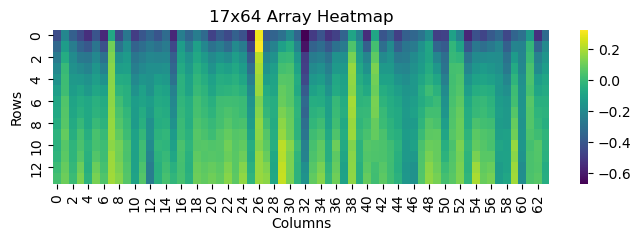

In [203]:
# 使用 Seaborn 绘制热图
plt.figure(figsize=(8, 2))
sns.heatmap(treat_vis, annot=False, cmap='viridis')
plt.title('17x64 Array Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [214]:
start_date = '2023-04-01 00:00:00'
target_time = '2024-03-01 00:00:00'

# 将日期字符串转换为 datetime 对象
start_date = pd.to_datetime(start_date)
target_time = pd.to_datetime(target_time)

# 计算时间差
time_difference = target_time - start_date

# 将时间差转换为小时数
time_idx = int(time_difference.total_seconds() / 3600)
print(time_idx)

device = 'cuda:0'

responses = np.zeros((490, 24, len(selected)))

allresponses = {}

with torch.no_grad():
        
    indice, x, y, _, _, adj = data[time_idx]
    mask = None
    causal_model.eval()

    indice = torch.LongTensor(indice)
    t = torch.LongTensor([calculate_week_hour(i.numpy().tolist()) for i in indice[:input_window]])
    #t = indice[:self.args.input_window] % self.args.tim_num  # 获取时间步
    t = t.unsqueeze(1).expand(-1, x.shape[1])  # 扩展时间步的维度

    x = x.unsqueeze(0).unsqueeze(-1).to(device).float()
    y = y.unsqueeze(0).to(device)
    t = t.unsqueeze(0).to(device)
    adj = adj.unsqueeze(0).to(device)
    for i, label in enumerate(selected):
        print(i)
        for idx in selected[label]:
            treat = alltreats[idx//490][1][0, :, idx % 490, :].unsqueeze(1).repeat(1, 490, 1).unsqueeze(0).to(device)
            y_pre, _, _, _ = causal_model(x, t, treat, adj)
            for j in range(output_window):  
                y_pred = torch.flatten(scaler.inverse_transform(y_pre[:, j].detach().cpu().unsqueeze(0))).detach().numpy()
                y_true = torch.flatten(scaler.inverse_transform(y[:, j].detach().cpu().squeeze())).detach().numpy()
#                 y_pred = torch.flatten(y_pre[:, j].detach().cpu().unsqueeze(0)).detach().numpy()
#                 y_true = torch.flatten(y[:, j].detach().cpu().squeeze()).detach().numpy()
                responses[:, j, i] += y_pred - y_true

8040
0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [231]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 例如：SimHei 是支持中文和日语的字体之一
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [234]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 列出系统上可用的字体
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# 打印出所有字体列表，找到支持日语字符的字体
for font in font_list:
    print(font)

# 设置字体，确保字体文件路径正确
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']  # 例如：Noto Sans CJK JP 是支持日语的字体
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


/usr/share/fonts/truetype/malayalam/Uroob-Regular.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSerif-BoldItalic.ttf
/usr/share/fonts/truetype/tlwg/Sawasdee-Bold.ttf
/usr/share/fonts/truetype/ttf-khmeros-core/KhmerOSsys.ttf
/usr/share/fonts/truetype/ubuntu/Ubuntu-LI.ttf
/usr/share/fonts/truetype/lato/Lato-SemiboldItalic.ttf
/usr/share/fonts/truetype/fonts-beng-extra/LikhanNormal.ttf
/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf
/usr/share/fonts/truetype/lato/Lato-Bold.ttf
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc
/usr/share/fonts/truetype/freefont/FreeSansBoldOblique.ttf
/usr/share/fonts/opentype/cantarell/Cantarell-Light.otf
/usr/share/fonts/truetype/kacst/KacstOffice.ttf
/usr/share/fonts/truetype/Sahadeva/sahadeva.ttf
/usr/share/fonts/truetype/tlwg/Garuda-Oblique.ttf
/usr/share/fonts/truetype/lato/Lato-Heavy.ttf
/usr/share/fonts/truetype/noto/N

In [235]:
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc'

# 加载字体
font_prop = fm.FontProperties(fname=font_path)

/tmp/ipykernel_3219427/2099627325.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3, 2))


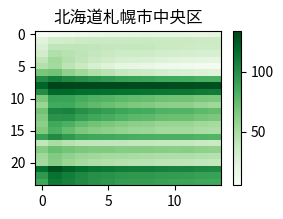

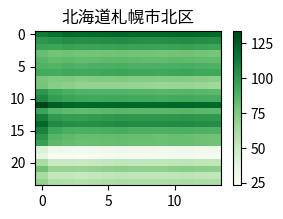

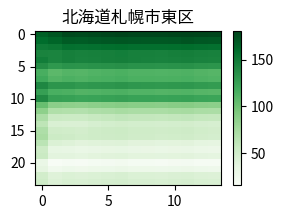

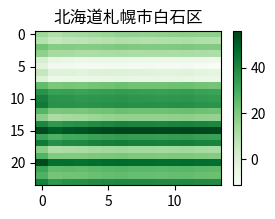

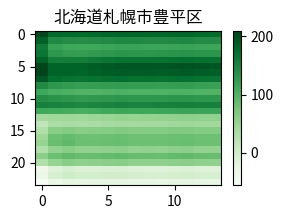

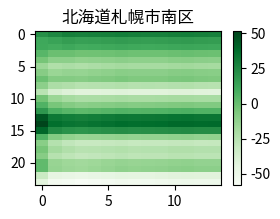

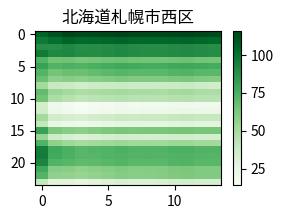

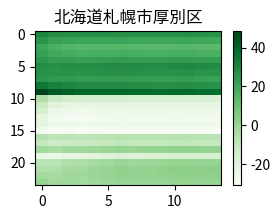

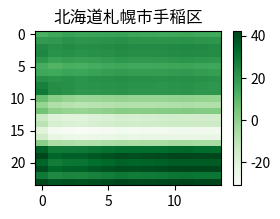

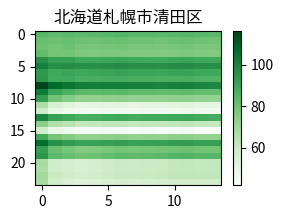

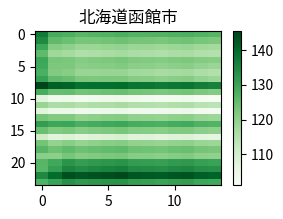

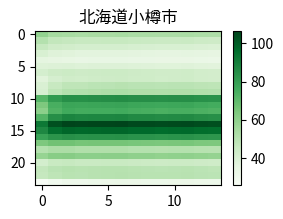

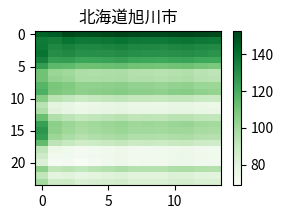

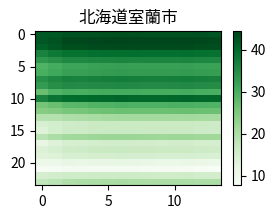

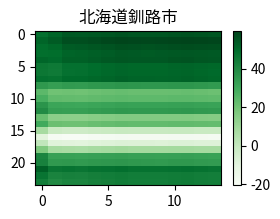

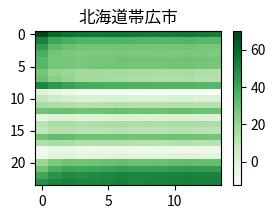

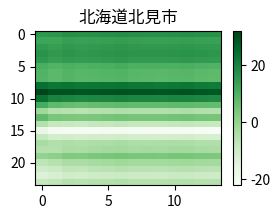

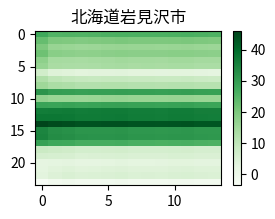

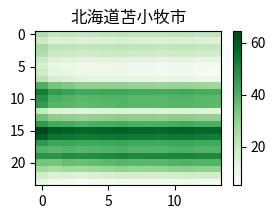

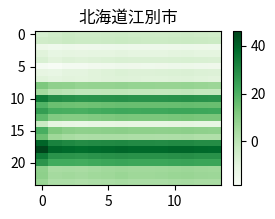

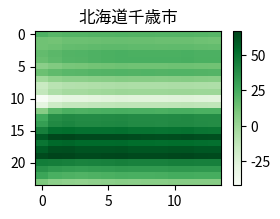

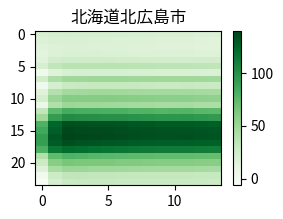

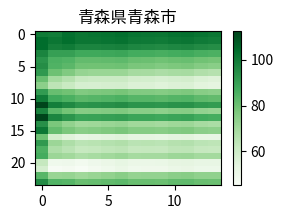

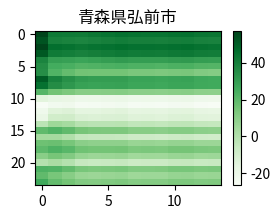

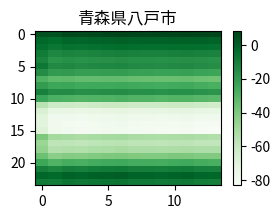

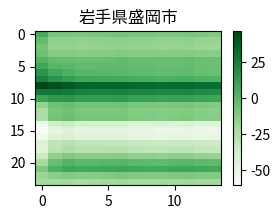

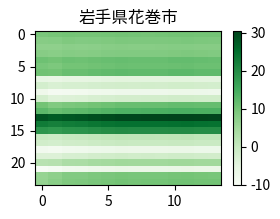

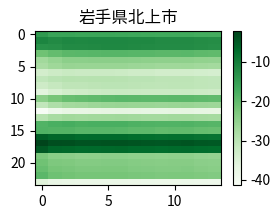

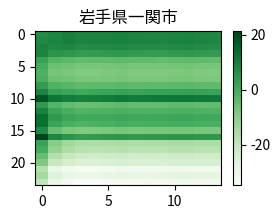

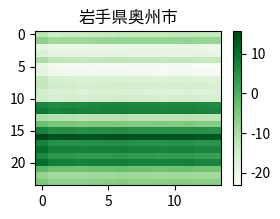

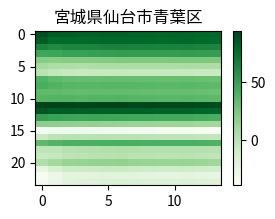

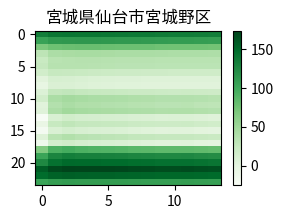

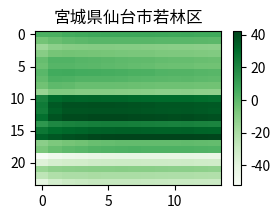

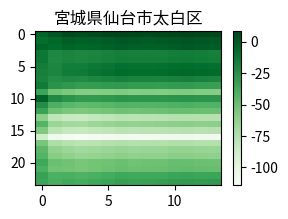

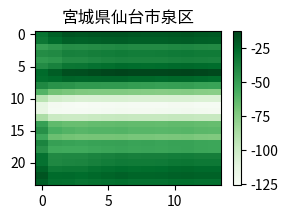

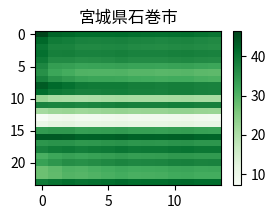

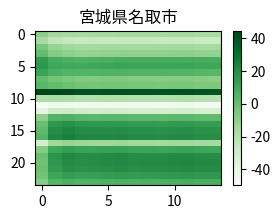

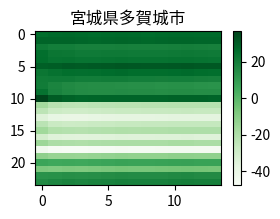

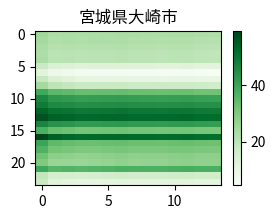

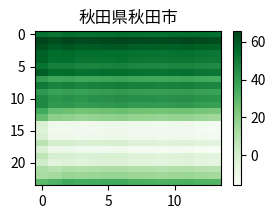

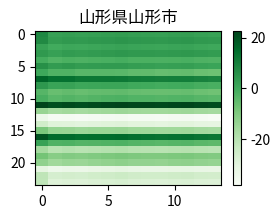

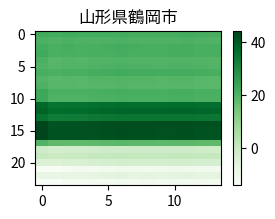

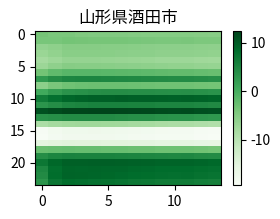

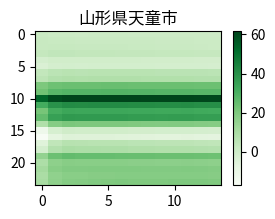

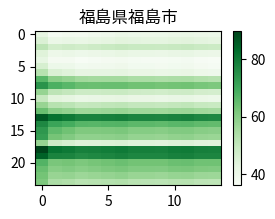

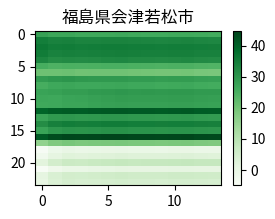

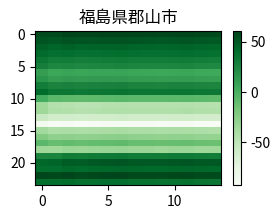

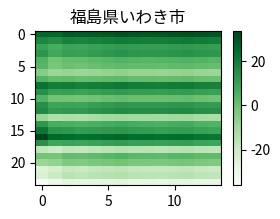

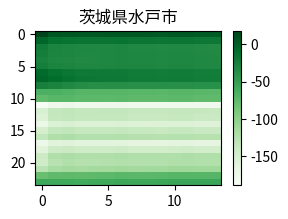

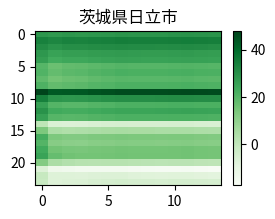

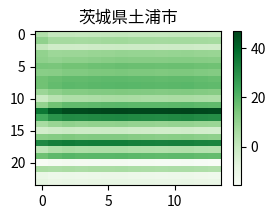

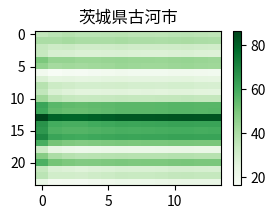

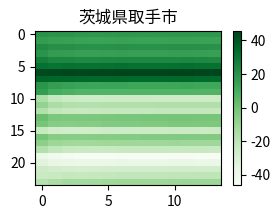

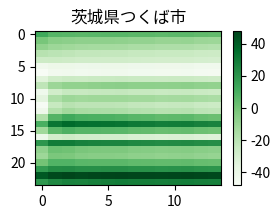

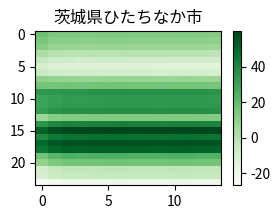

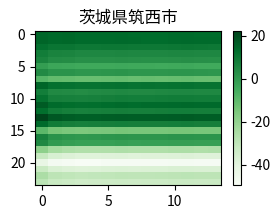

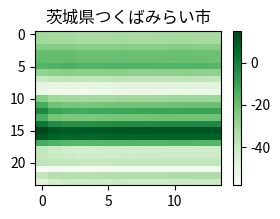

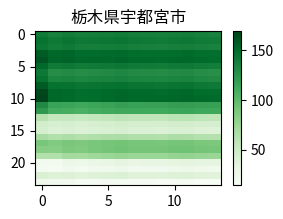

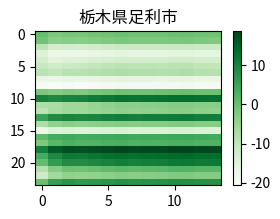

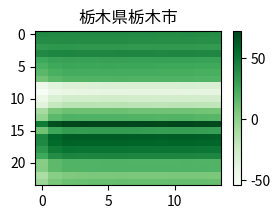

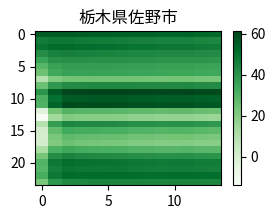

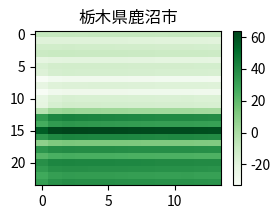

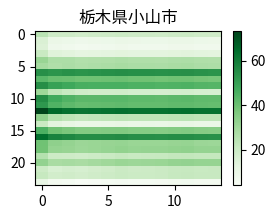

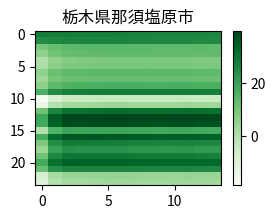

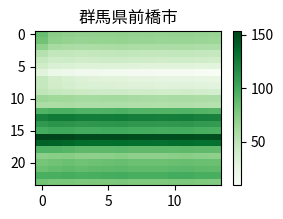

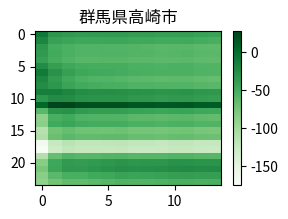

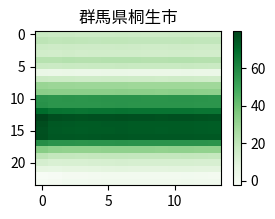

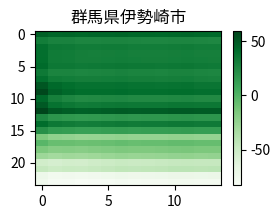

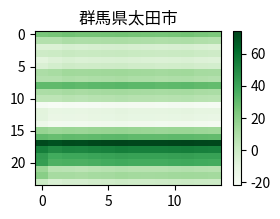

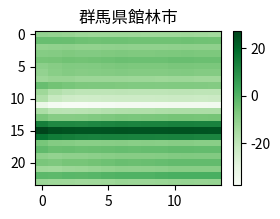

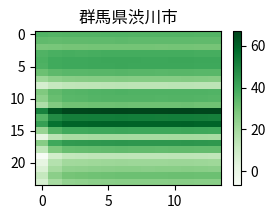

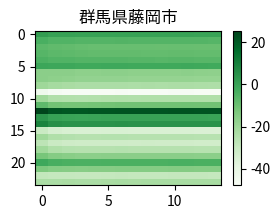

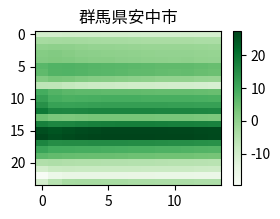

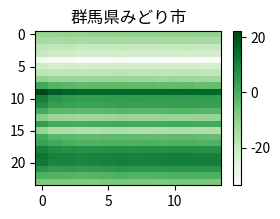

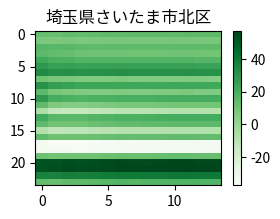

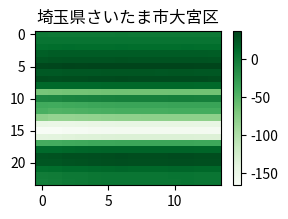

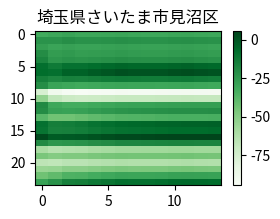

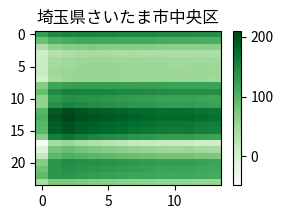

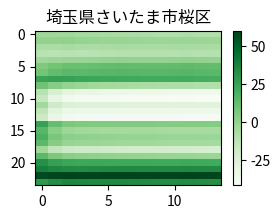

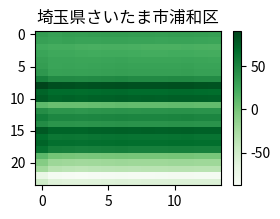

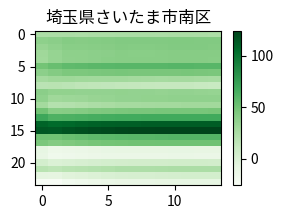

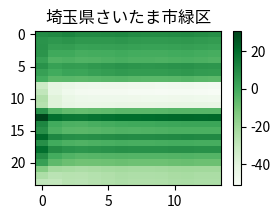

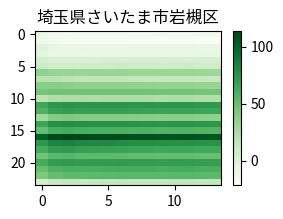

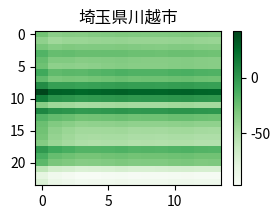

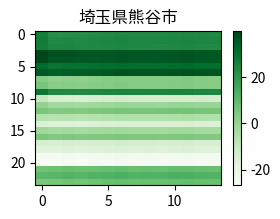

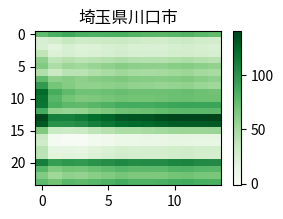

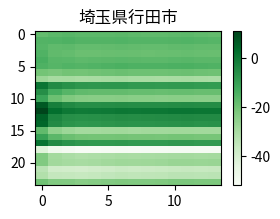

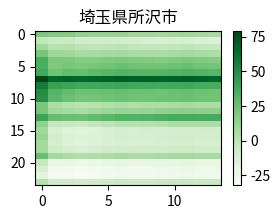

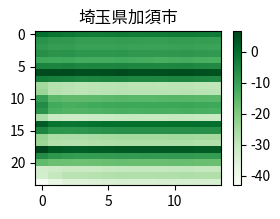

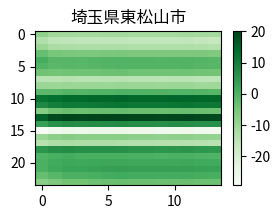

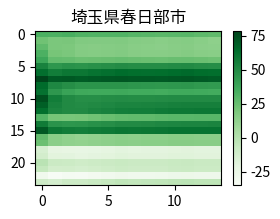

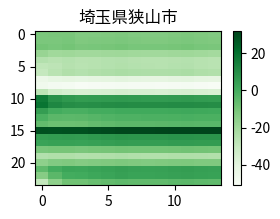

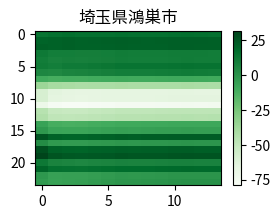

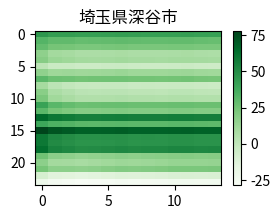

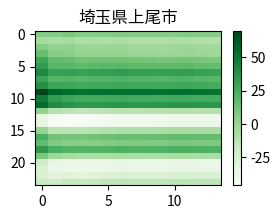

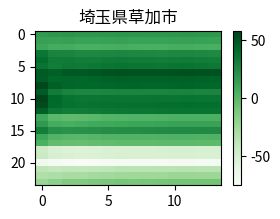

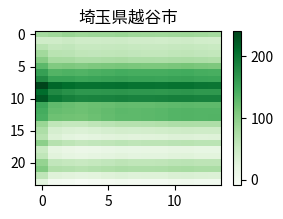

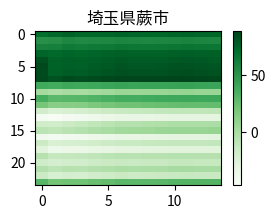

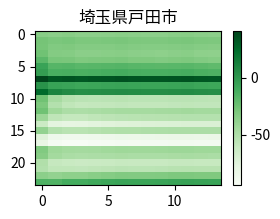

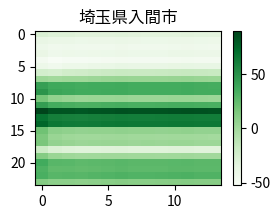

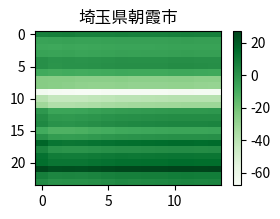

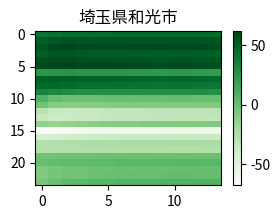

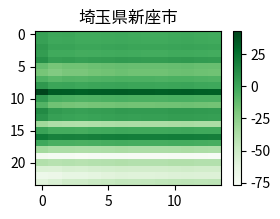

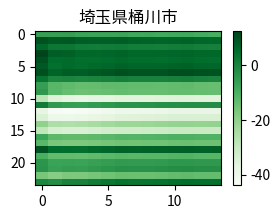

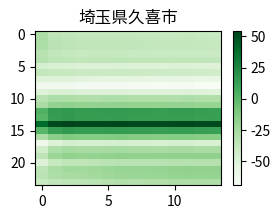

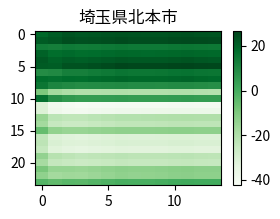

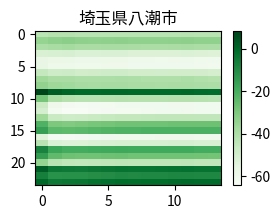

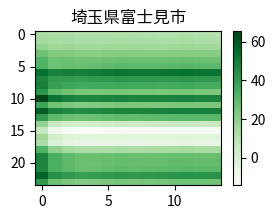

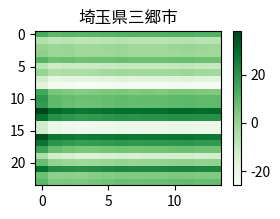

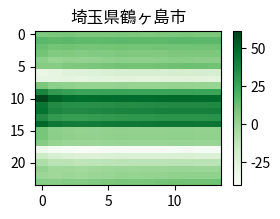

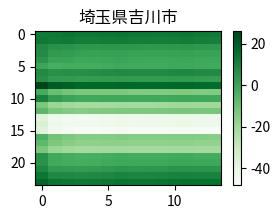

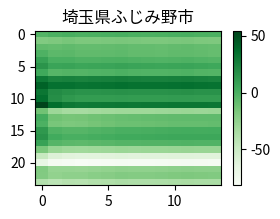

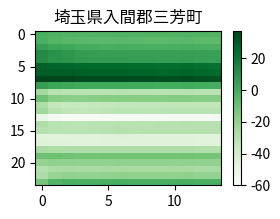

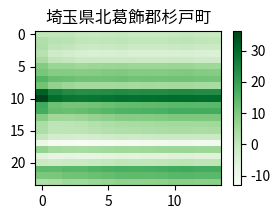

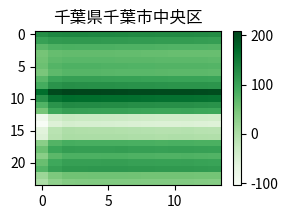

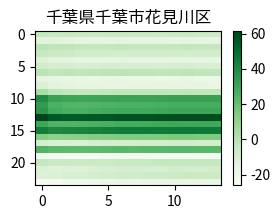

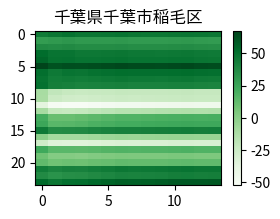

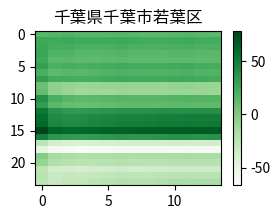

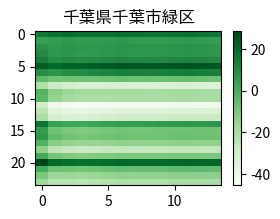

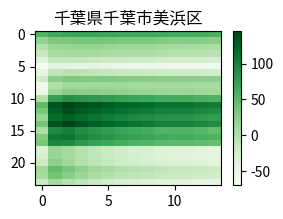

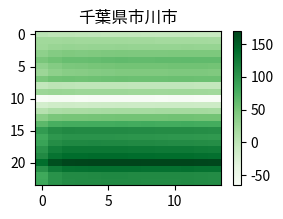

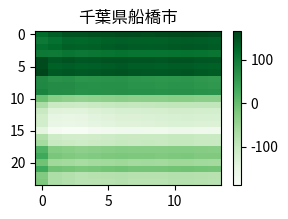

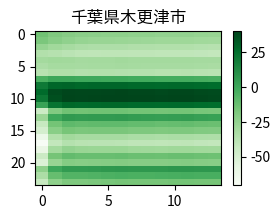

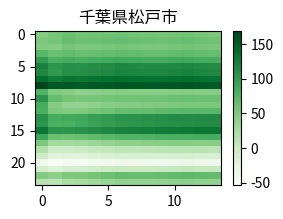

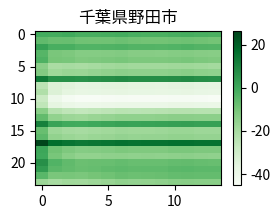

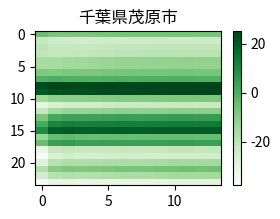

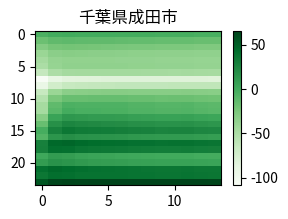

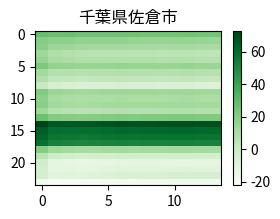

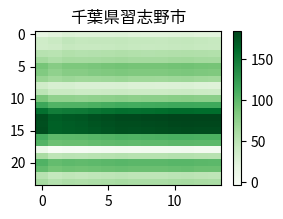

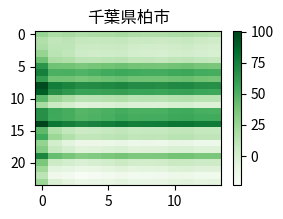

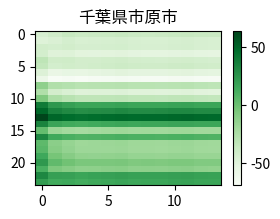

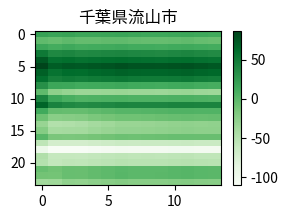

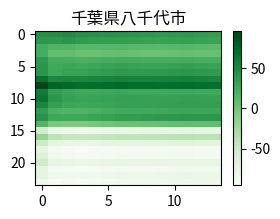

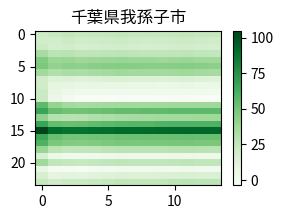

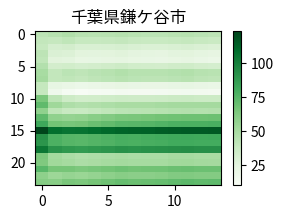

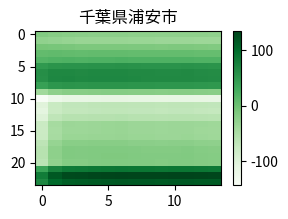

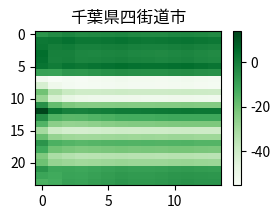

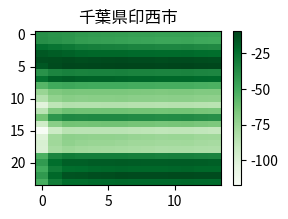

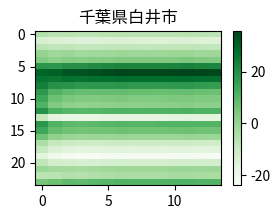

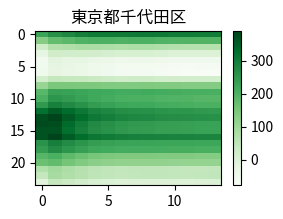

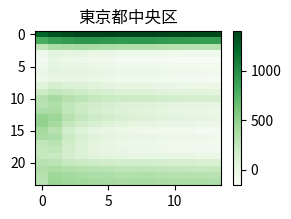

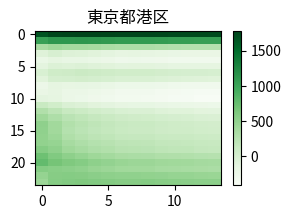

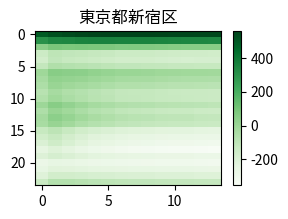

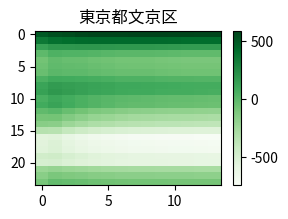

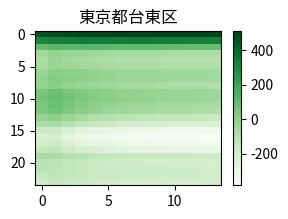

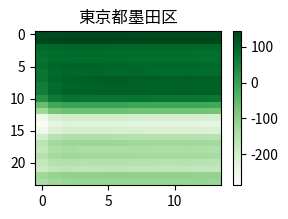

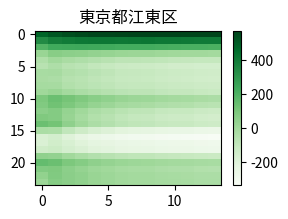

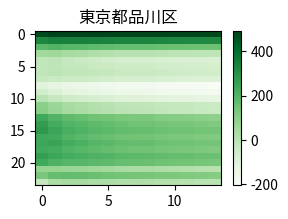

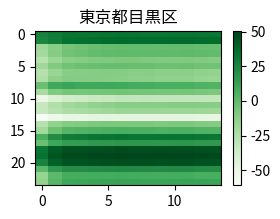

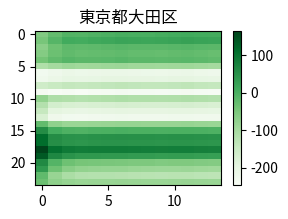

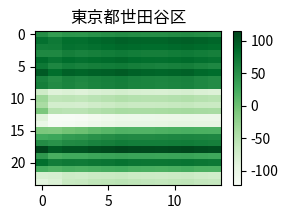

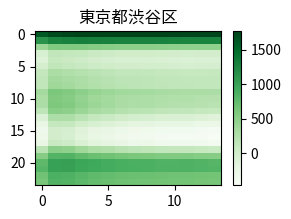

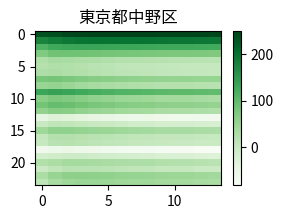

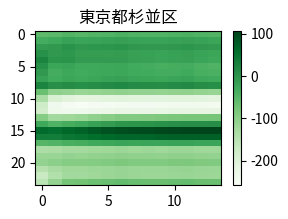

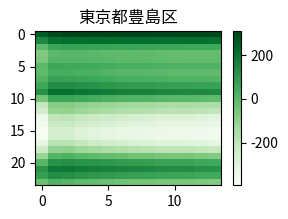

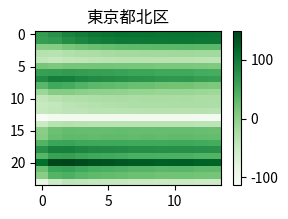

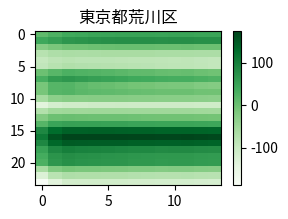

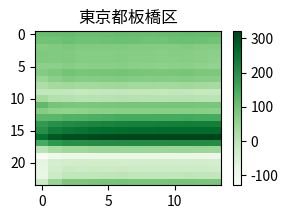

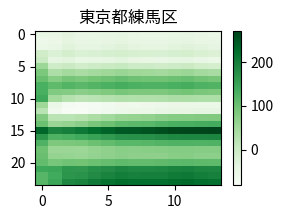

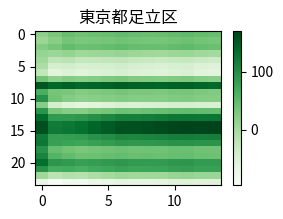

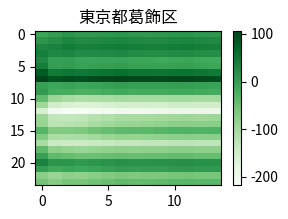

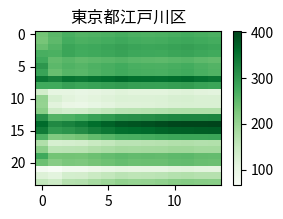

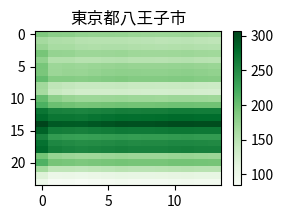

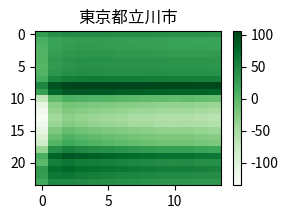

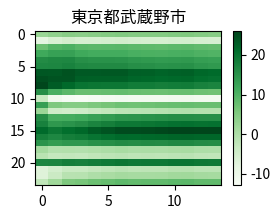

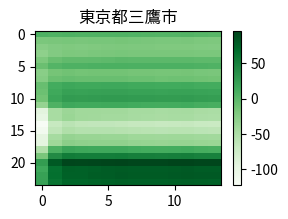

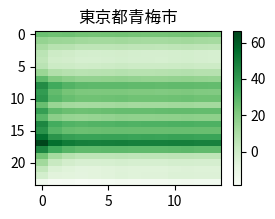

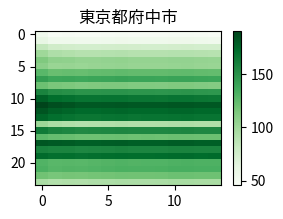

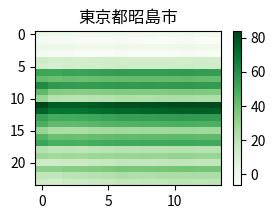

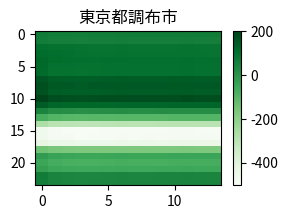

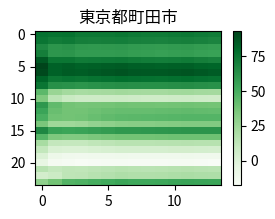

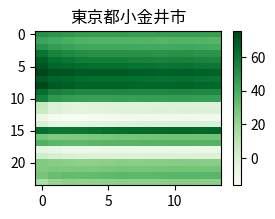

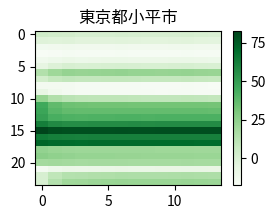

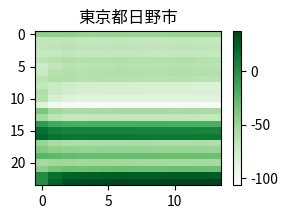

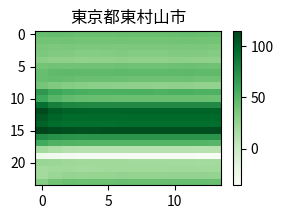

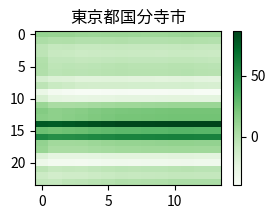

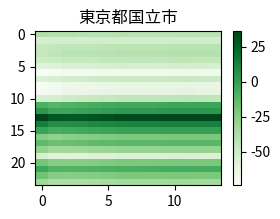

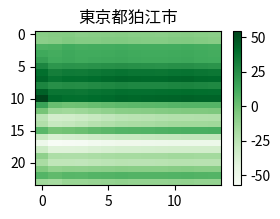

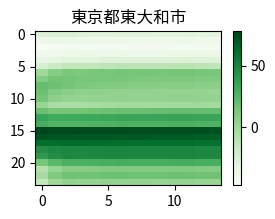

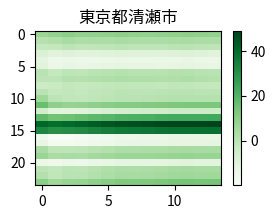

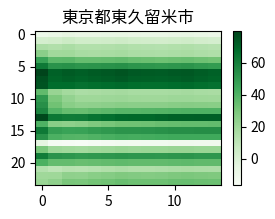

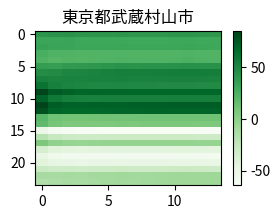

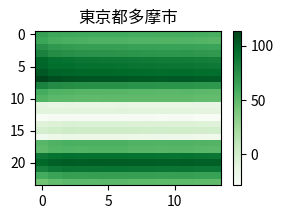

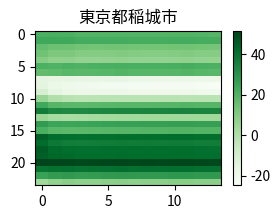

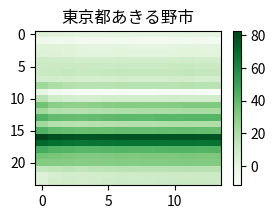

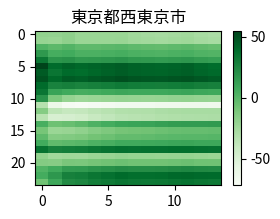

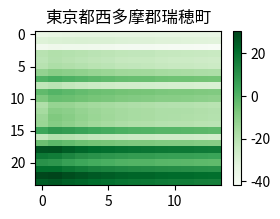

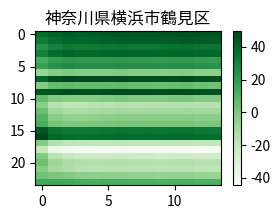

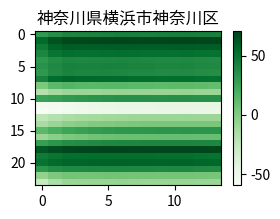

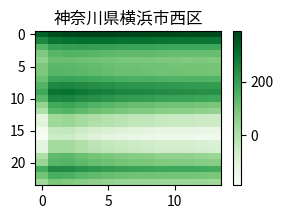

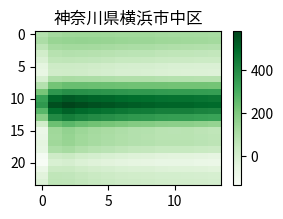

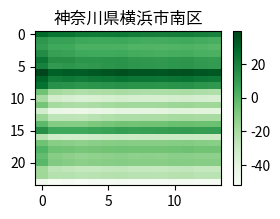

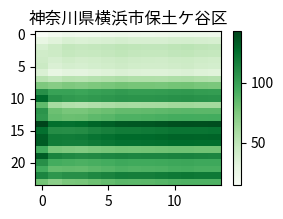

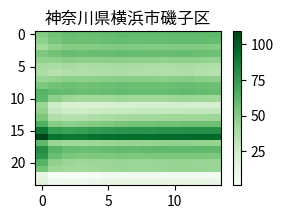

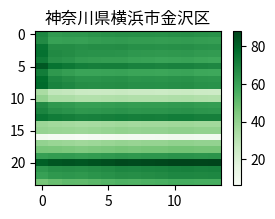

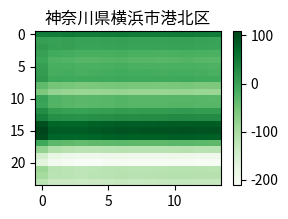

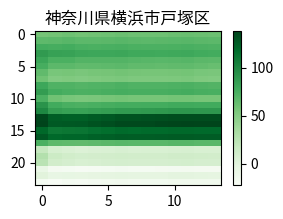

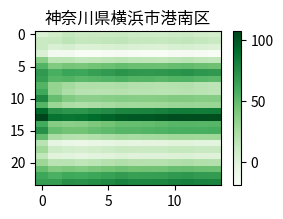

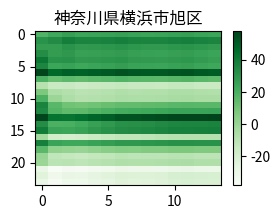

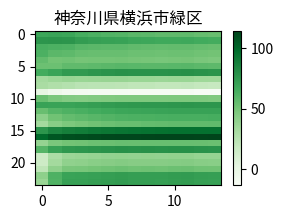

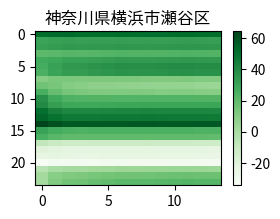

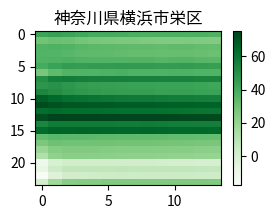

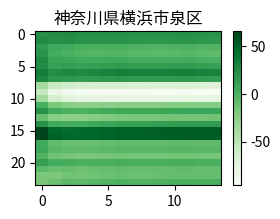

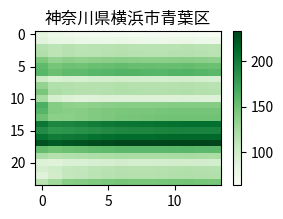

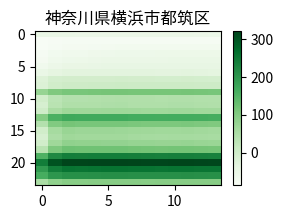

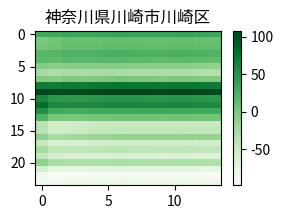

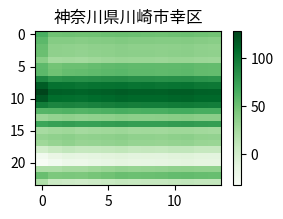

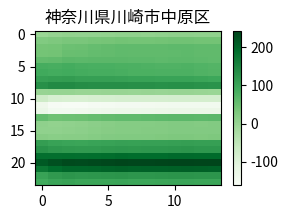

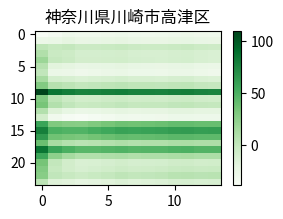

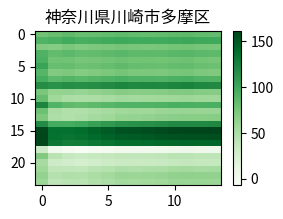

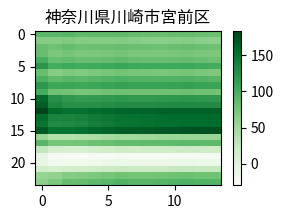

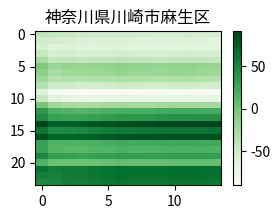

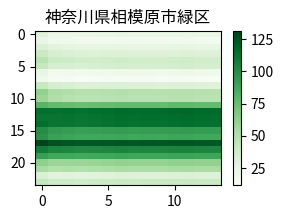

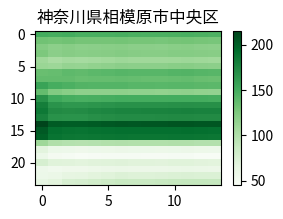

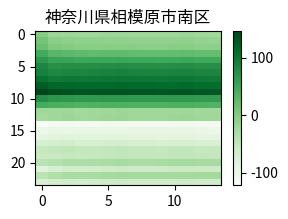

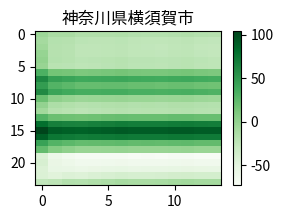

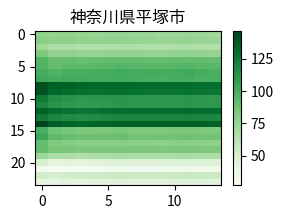

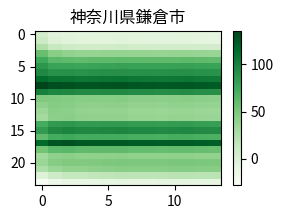

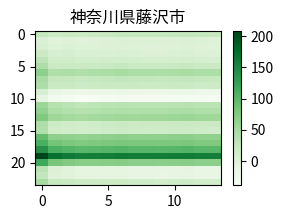

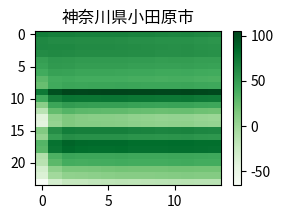

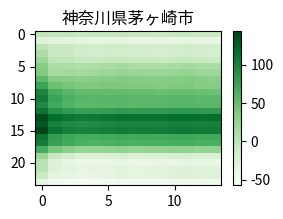

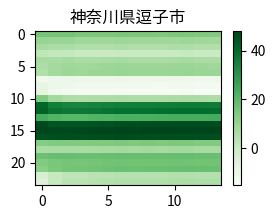

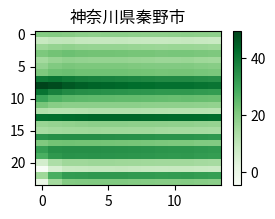

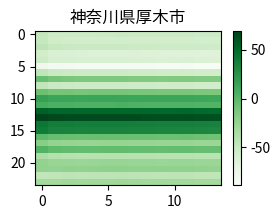

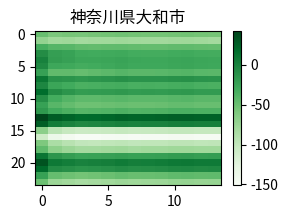

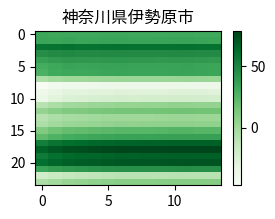

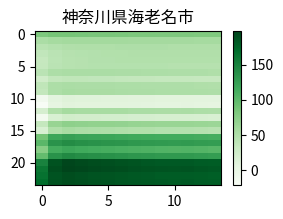

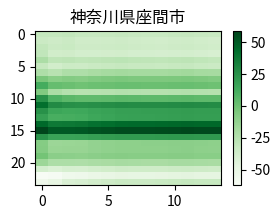

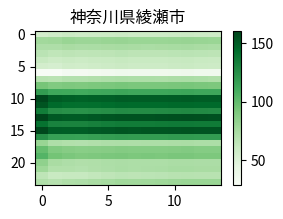

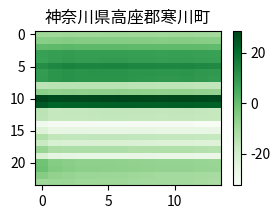

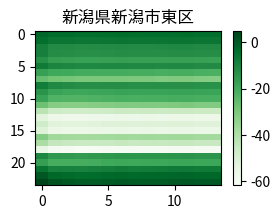

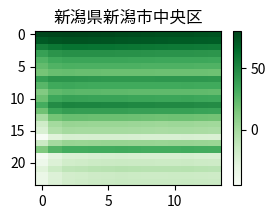

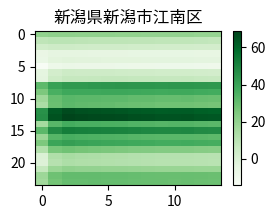

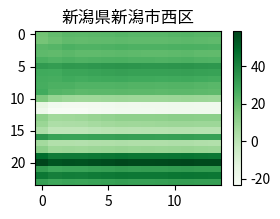

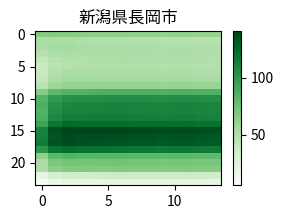

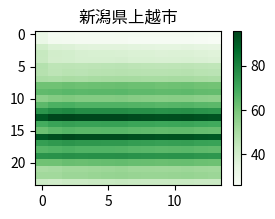

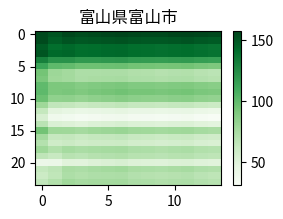

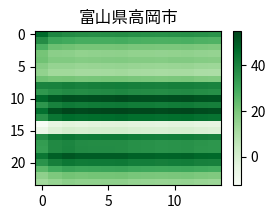

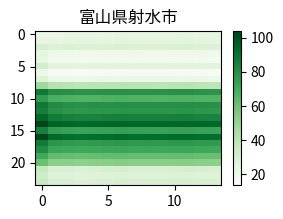

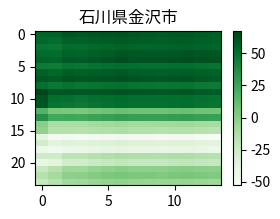

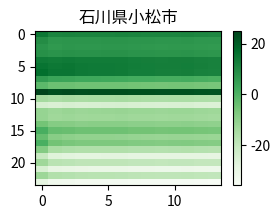

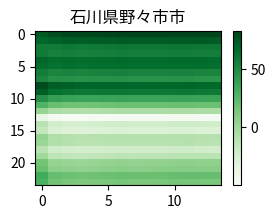

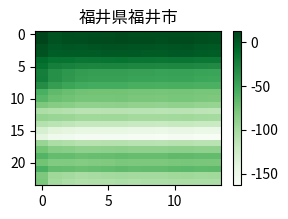

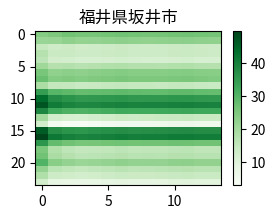

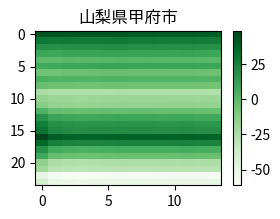

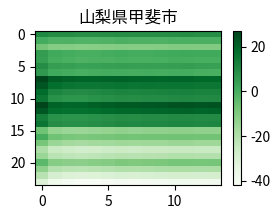

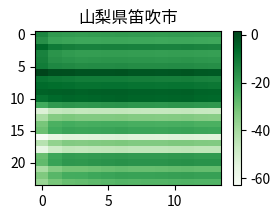

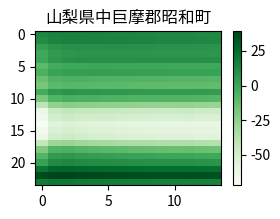

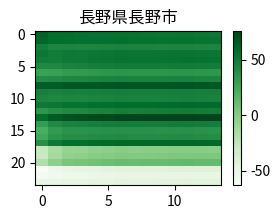

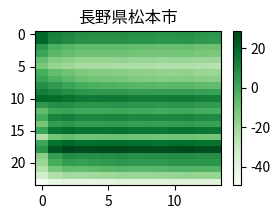

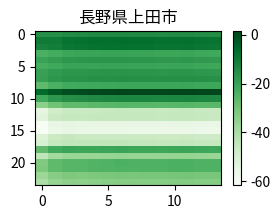

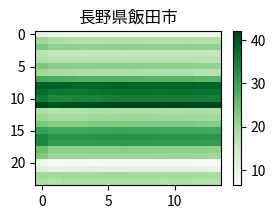

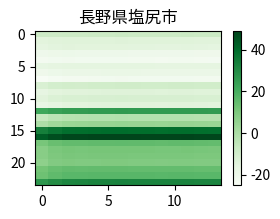

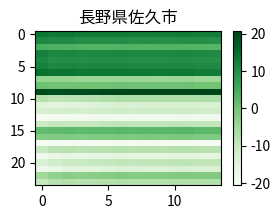

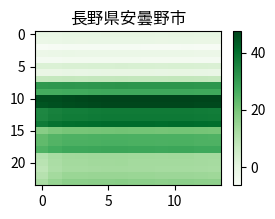

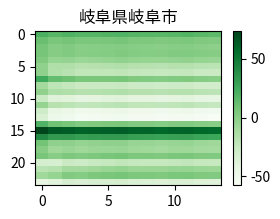

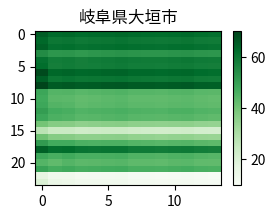

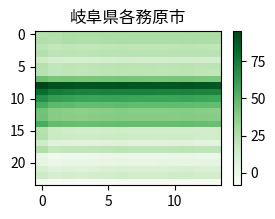

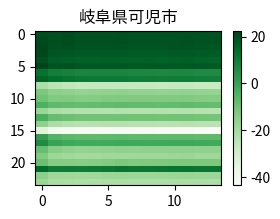

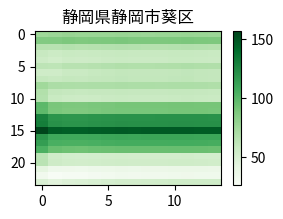

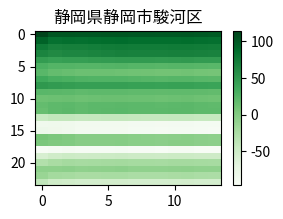

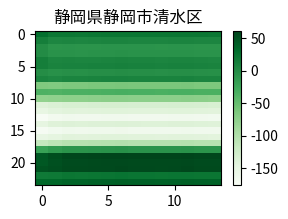

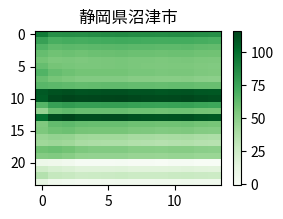

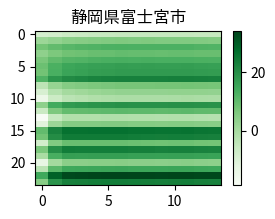

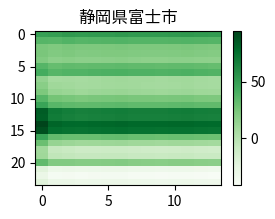

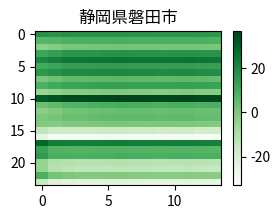

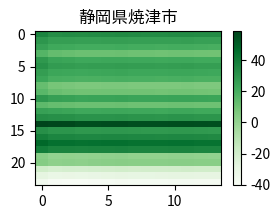

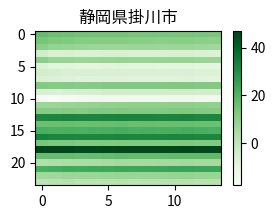

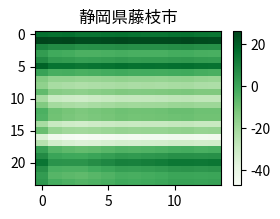

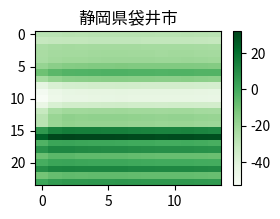

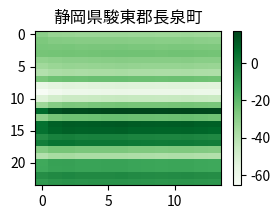

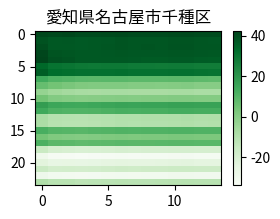

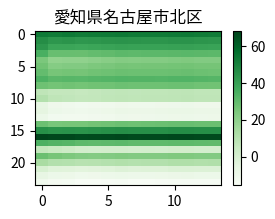

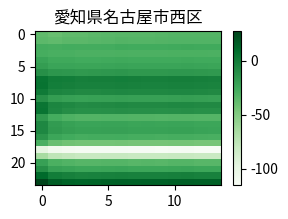

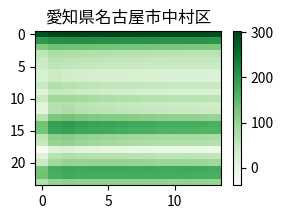

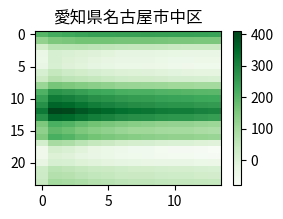

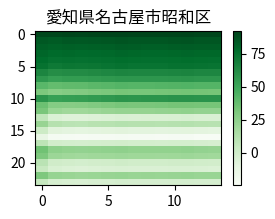

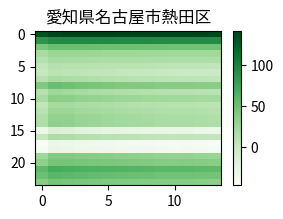

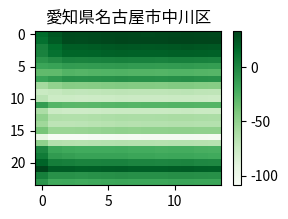

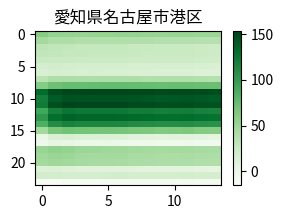

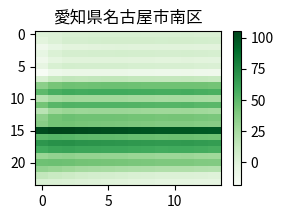

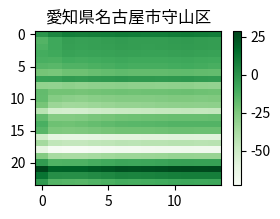

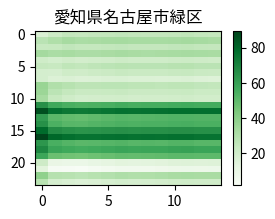

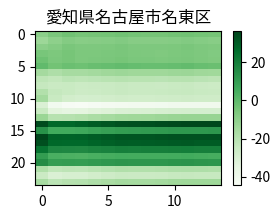

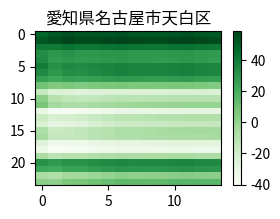

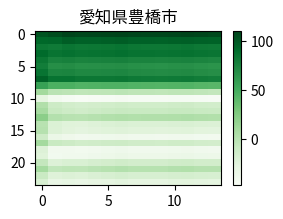

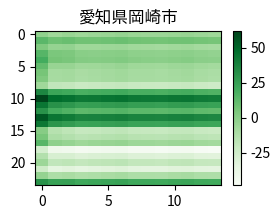

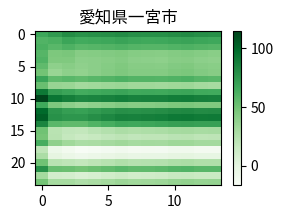

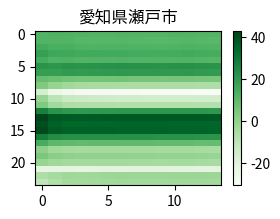

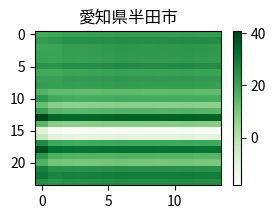

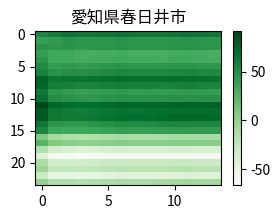

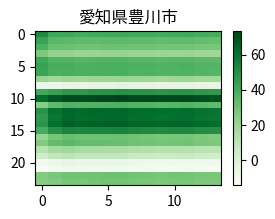

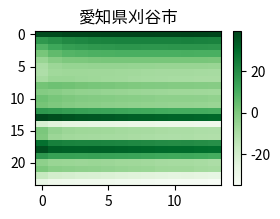

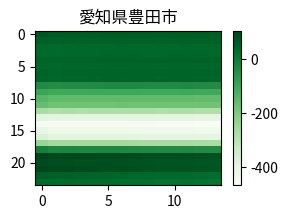

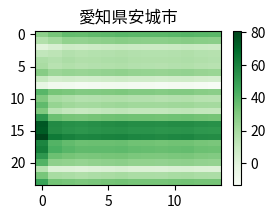

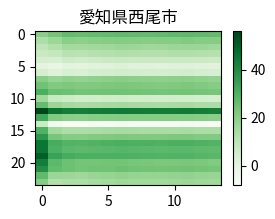

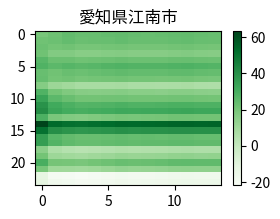

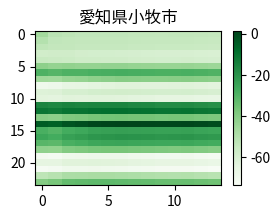

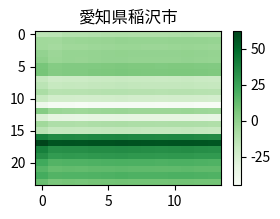

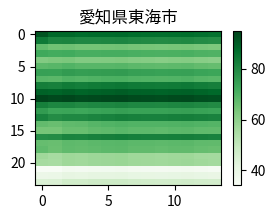

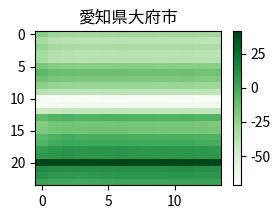

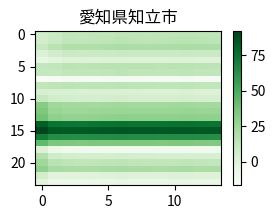

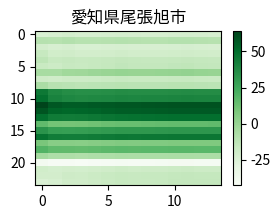

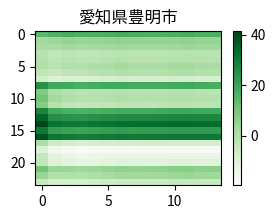

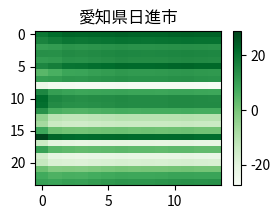

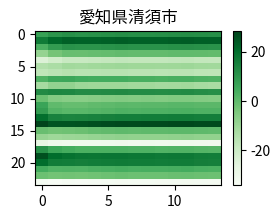

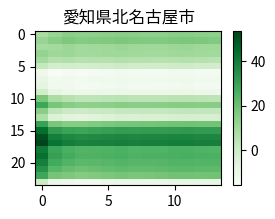

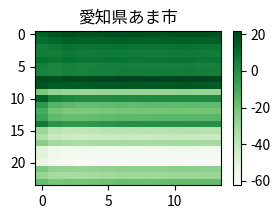

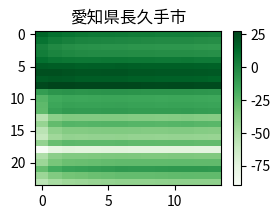

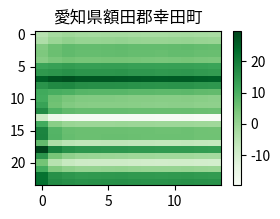

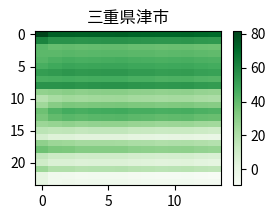

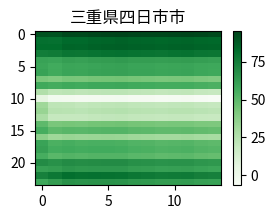

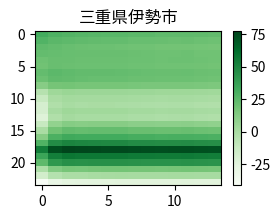

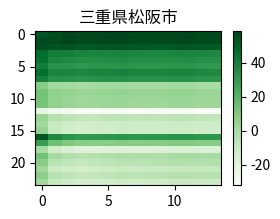

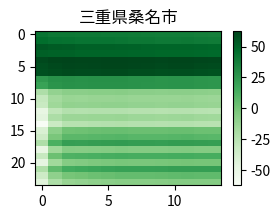

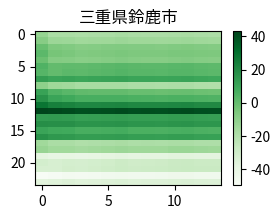

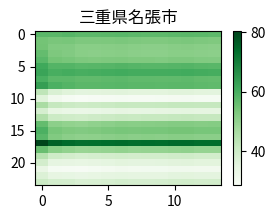

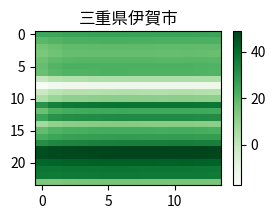

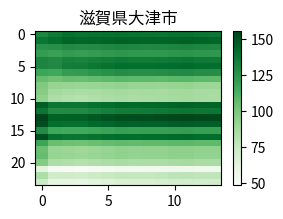

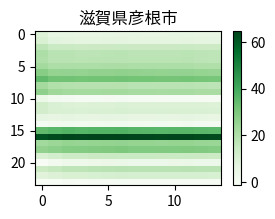

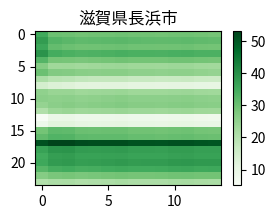

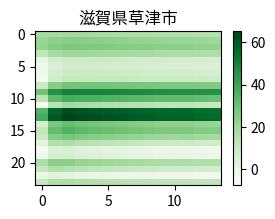

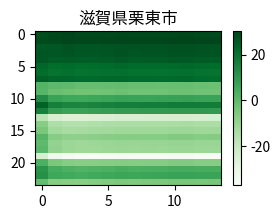

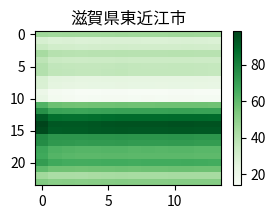

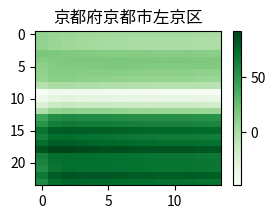

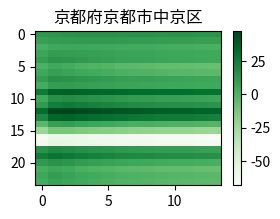

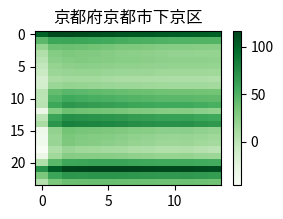

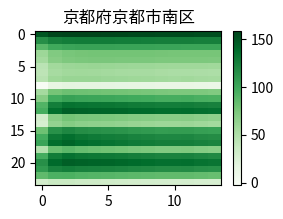

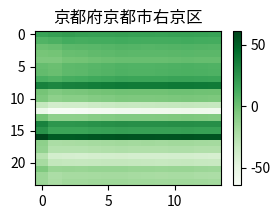

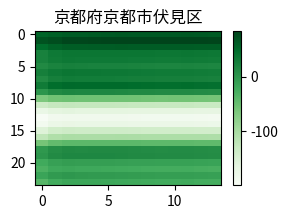

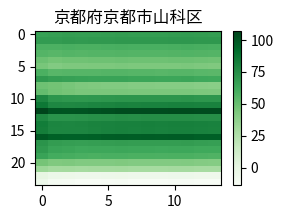

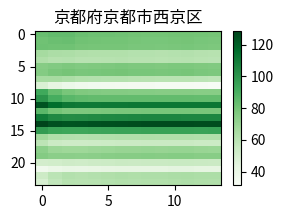

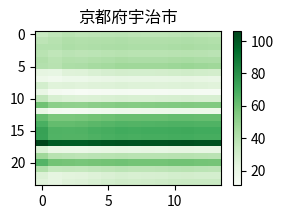

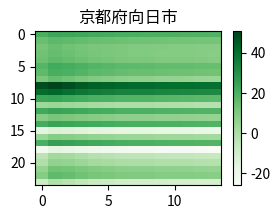

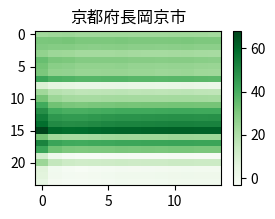

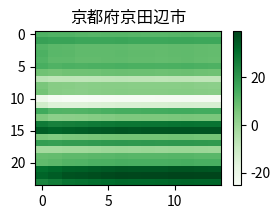

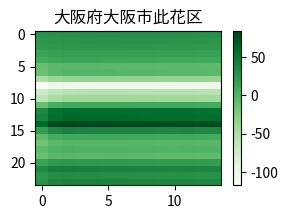

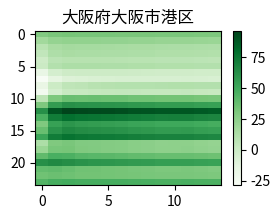

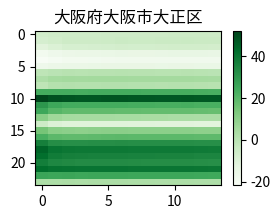

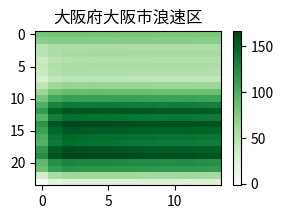

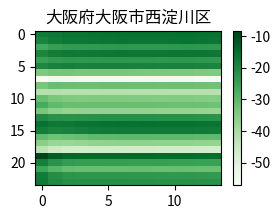

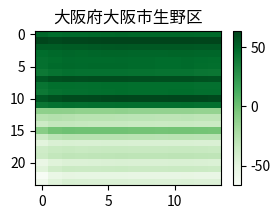

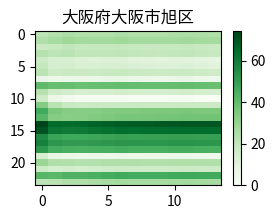

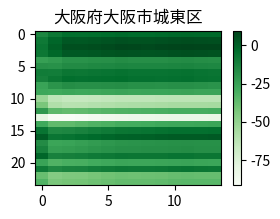

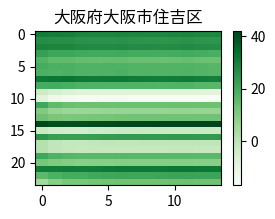

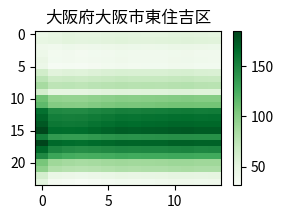

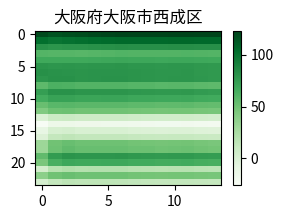

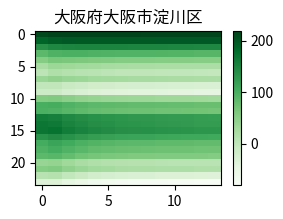

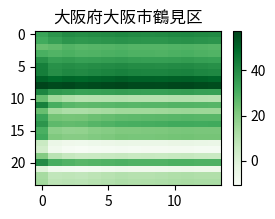

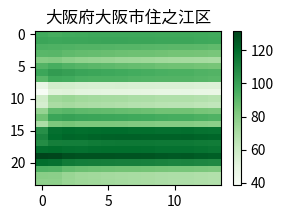

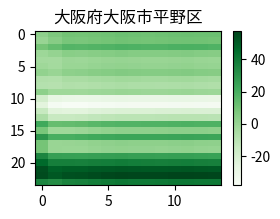

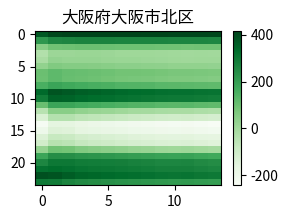

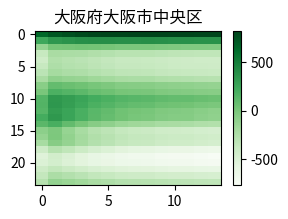

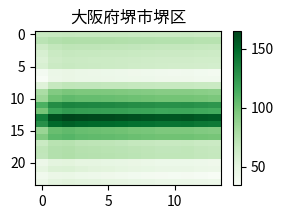

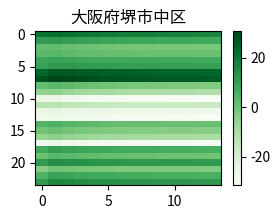

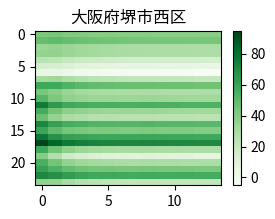

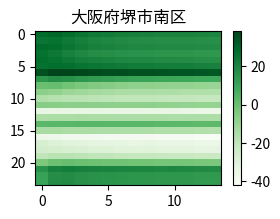

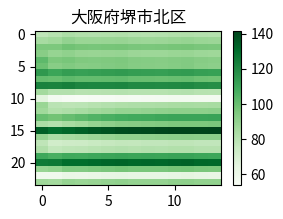

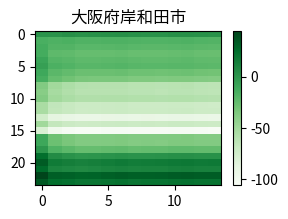

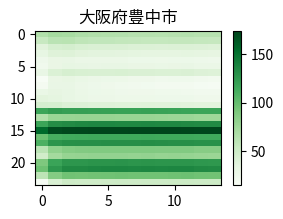

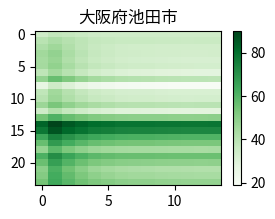

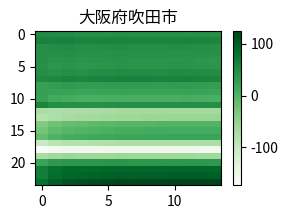

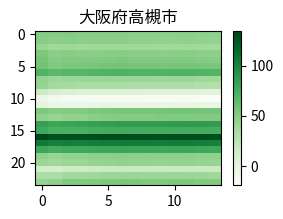

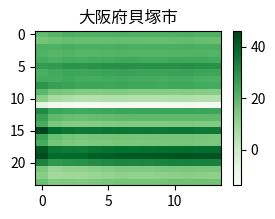

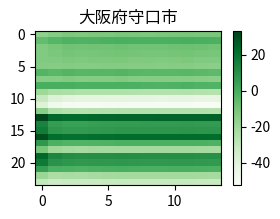

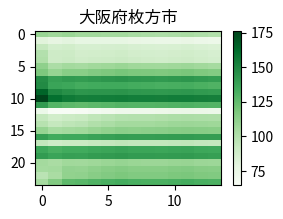

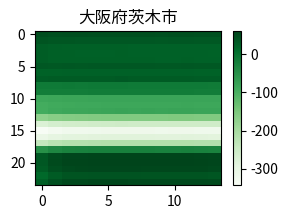

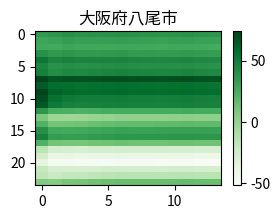

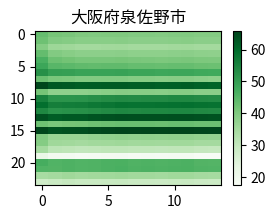

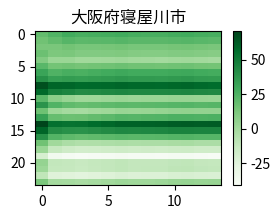

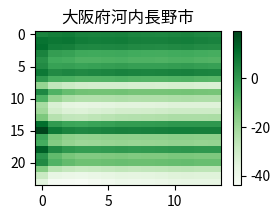

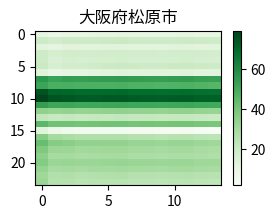

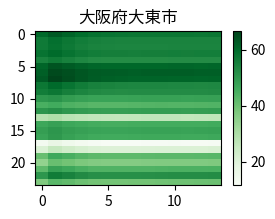

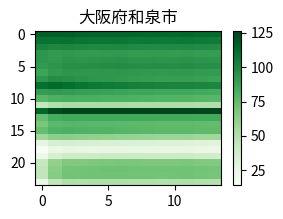

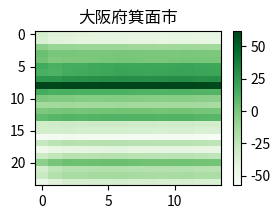

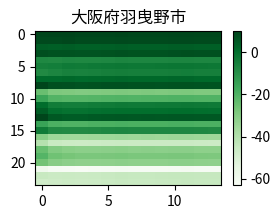

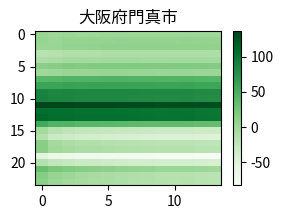

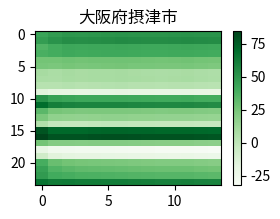

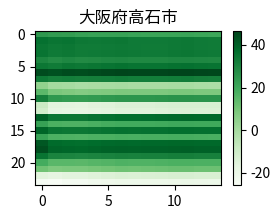

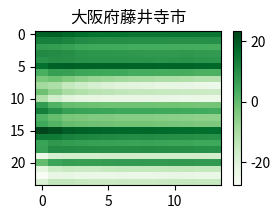

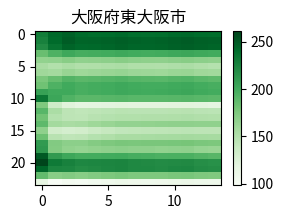

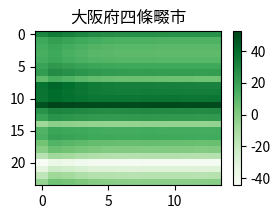

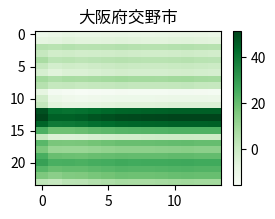

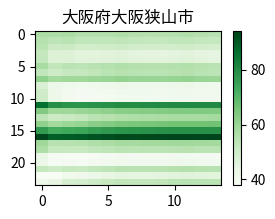

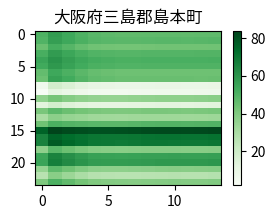

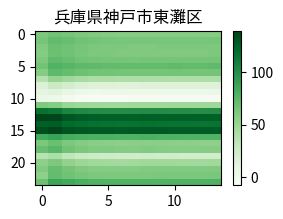

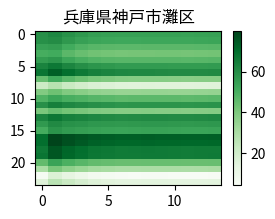

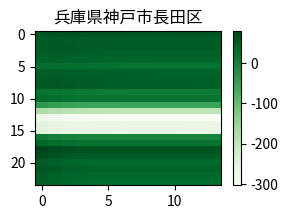

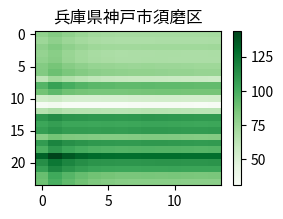

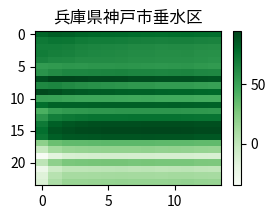

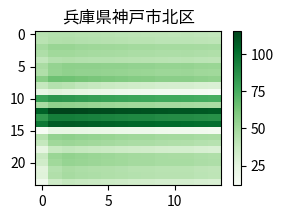

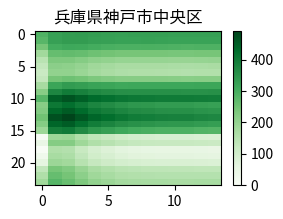

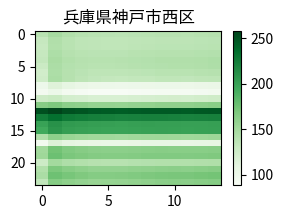

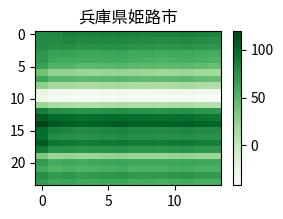

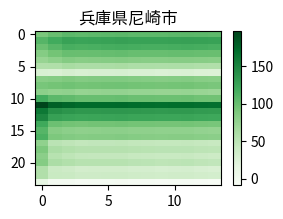

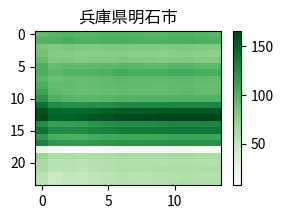

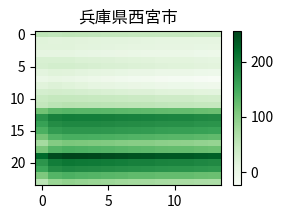

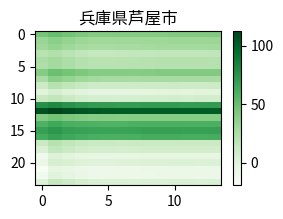

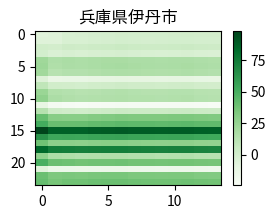

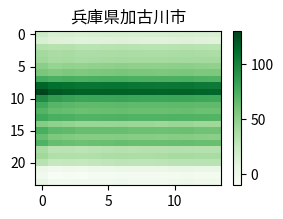

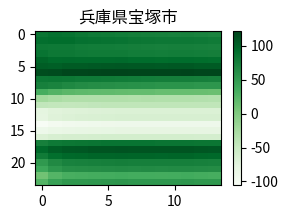

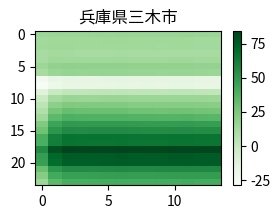

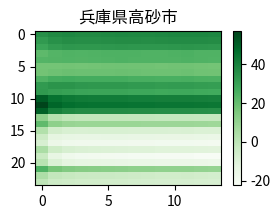

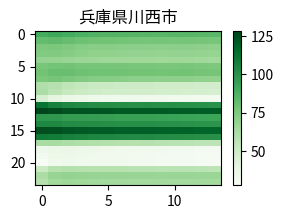

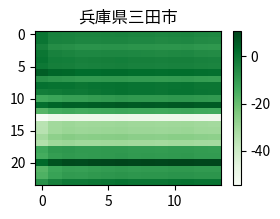

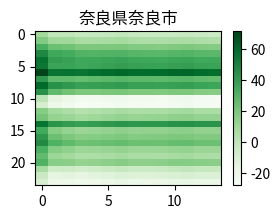

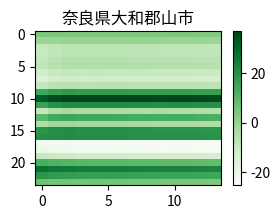

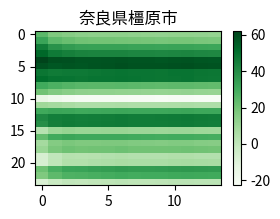

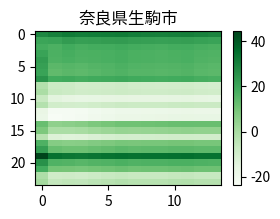

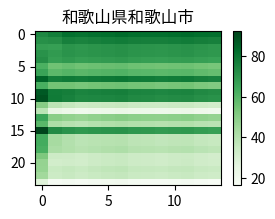

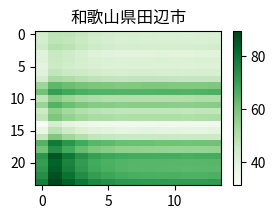

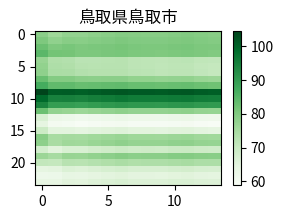

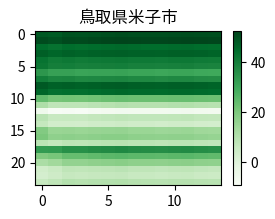

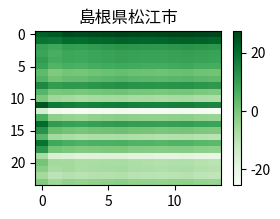

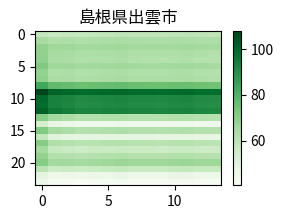

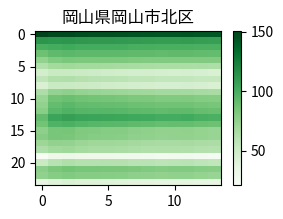

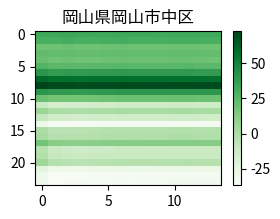

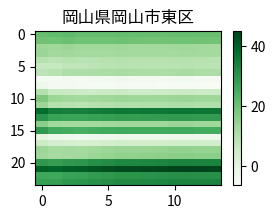

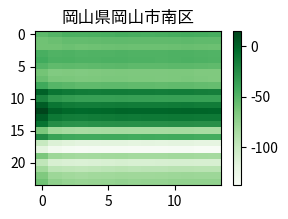

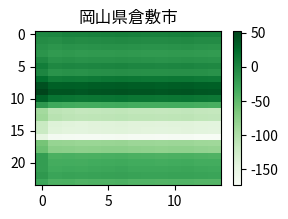

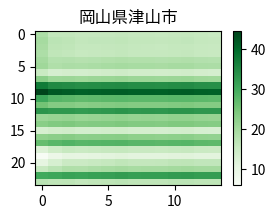

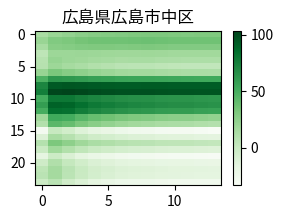

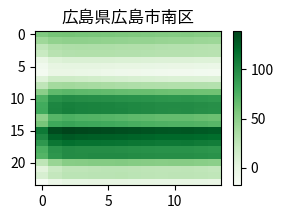

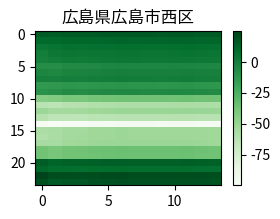

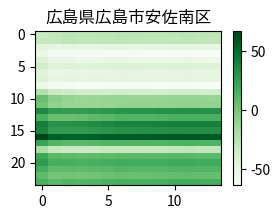

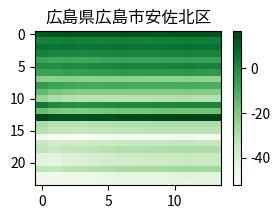

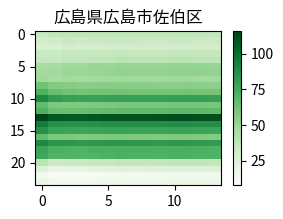

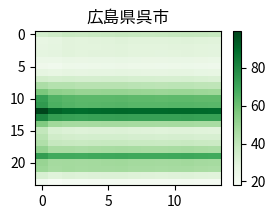

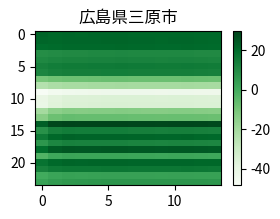

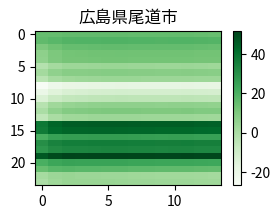

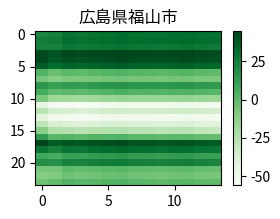

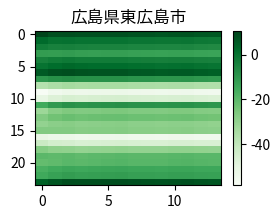

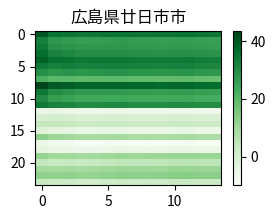

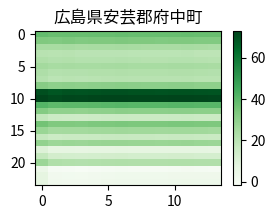

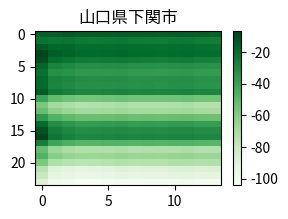

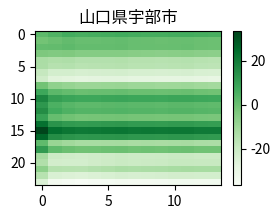

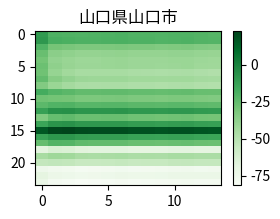

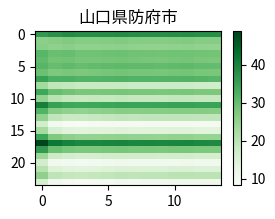

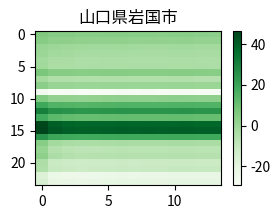

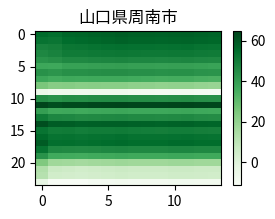

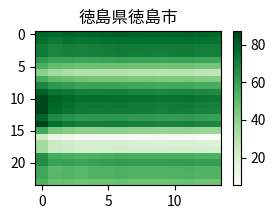

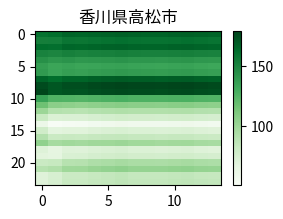

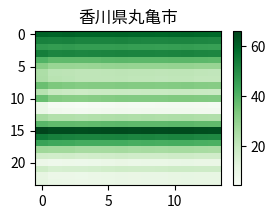

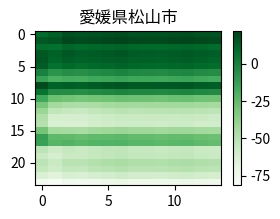

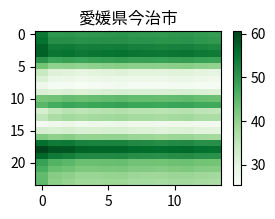

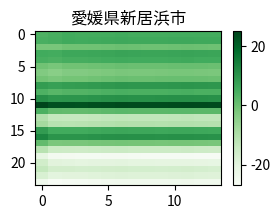

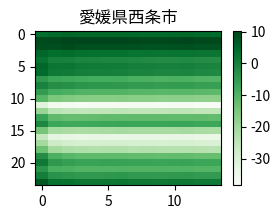

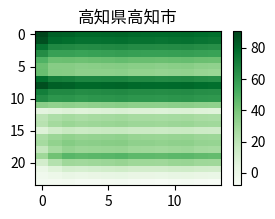

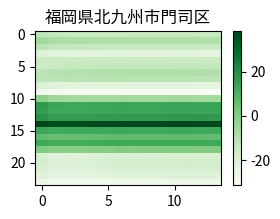

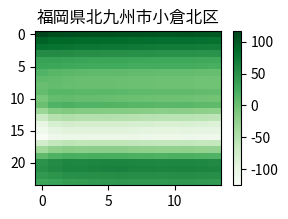

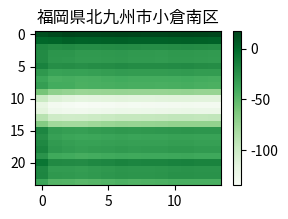

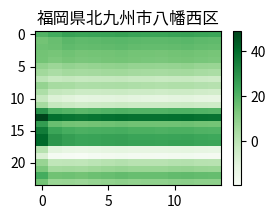

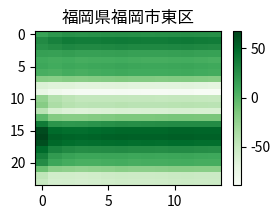

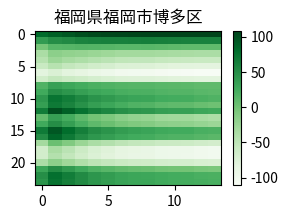

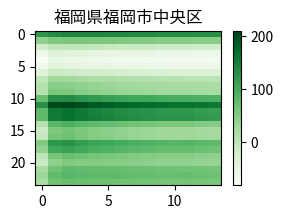

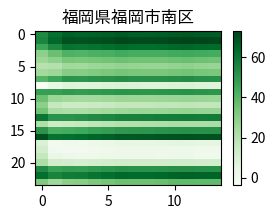

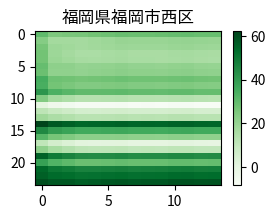

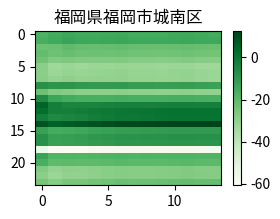

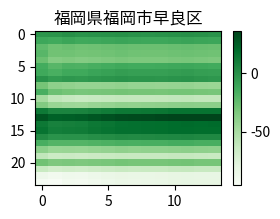

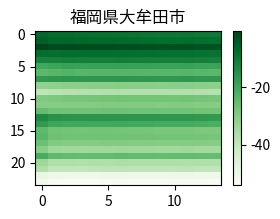

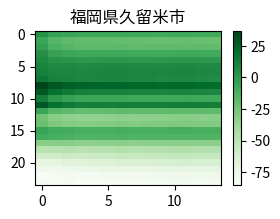

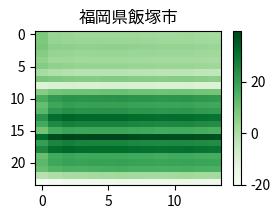

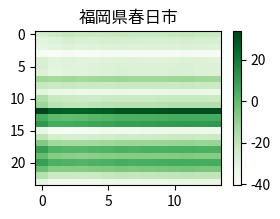

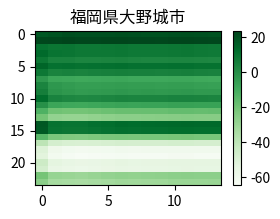

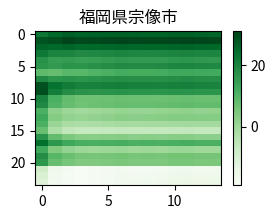

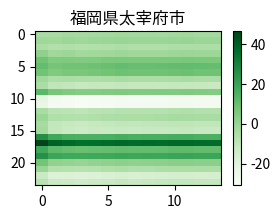

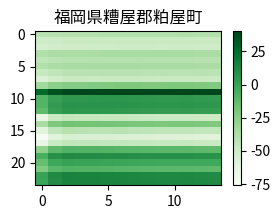

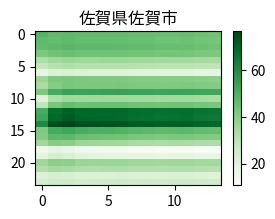

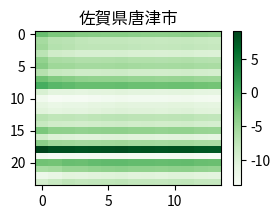

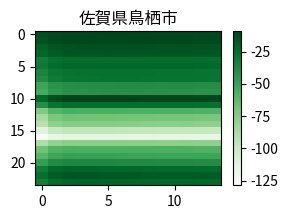

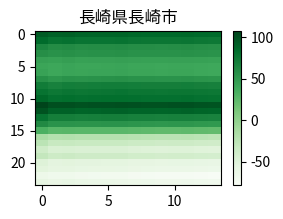

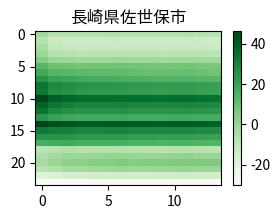

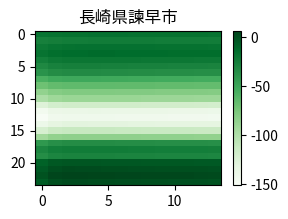

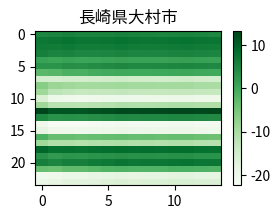

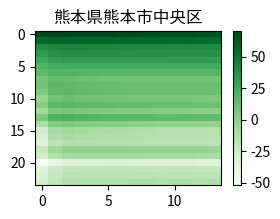

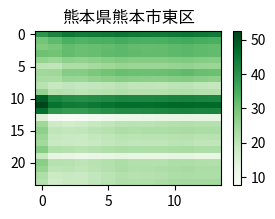

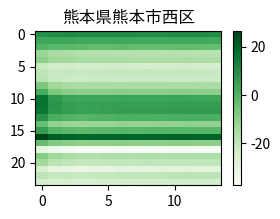

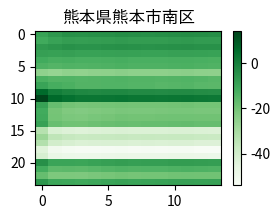

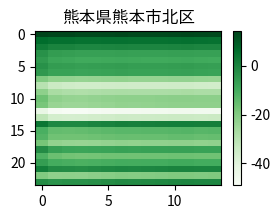

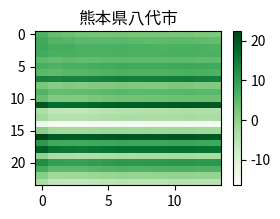

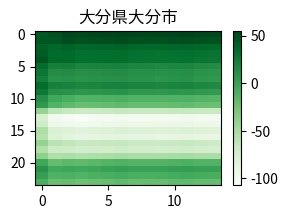

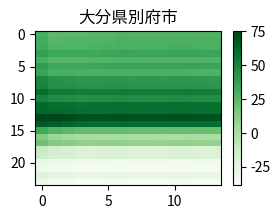

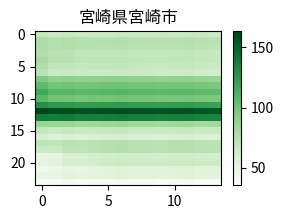

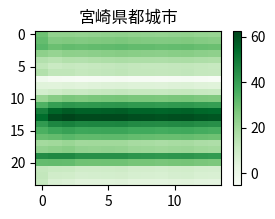

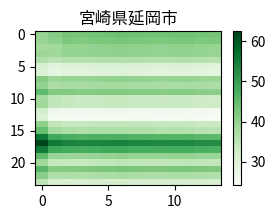

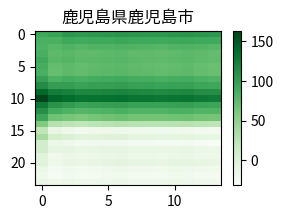

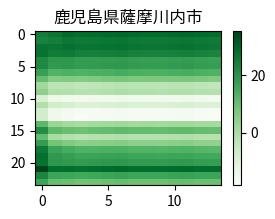

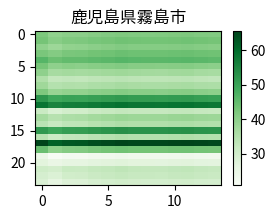

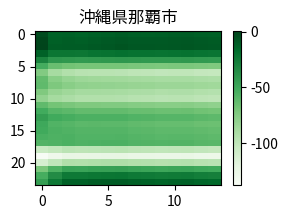

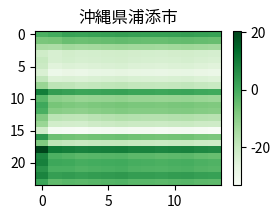

In [237]:
# 自定义图像大小，例如 width=10, height=5 (单位为英寸)
for i in range(0, 490, 1):
    plt.figure(figsize=(3, 2))
    plt.imshow(responses[i, ...]/ 50, aspect='auto', cmap = 'Greens')
    plt.title(code2region[idx2code[i]])
    plt.colorbar()  # 显示颜色条

In [229]:
code2region[idx2code[i]]

'大分県大分市'

In [ ]:
mean_res = responses.mean(axis = 1)
#mean_res = responses.mean(axis = 1)

In [ ]:
# 自定义图像大小，例如 width=10, height=5 (单位为英寸)
plt.figure(figsize=(16, 4))
plt.imshow(mean_res[np.argsort(mean_res.std(axis = 1)), :].transpose(), aspect='auto')
plt.colorbar()  # 显示颜色条

In [161]:
[code2region[idx2code[i]] for i in np.argsort(mean_res.mean(axis = 1))]

['長崎県諫早市',
 '佐賀県鳥栖市',
 '千葉県印西市',
 '茨城県水戸市',
 '福岡県大牟田市',
 '茨城県つくばみらい市',
 '長野県上田市',
 '大阪府大阪市西淀川区',
 '岡山県岡山市南区',
 '群馬県藤岡市',
 '新潟県新潟市東区',
 '埼玉県八潮市',
 '岩手県北上市',
 '福井県福井市',
 '山梨県笛吹市',
 '福岡県糟屋郡粕屋町',
 '山口県下関市',
 '山口県山口市',
 '埼玉県行田市',
 '東京都国立市',
 '東京都日野市',
 '埼玉県久喜市',
 '福岡県北九州市小倉南区',
 '宮城県仙台市泉区',
 '静岡県駿東郡長泉町',
 '千葉県茂原市',
 '大阪府茨木市',
 '熊本県熊本市南区',
 '愛知県小牧市',
 '大阪府羽曳野市',
 '静岡県袋井市',
 '群馬県高崎市',
 '愛知県名古屋市西区',
 '熊本県熊本市北区',
 '静岡県静岡市清水区',
 '沖縄県那覇市',
 '埼玉県加須市',
 '広島県広島市安佐北区',
 '埼玉県戸田市',
 '埼玉県さいたま市大宮区',
 '福岡県久留米市',
 '熊本県熊本市西区',
 '兵庫県神戸市長田区',
 '広島県東広島市',
 '愛知県長久手市',
 '福岡県春日市',
 '愛知県大府市',
 '愛知県豊田市',
 '埼玉県入間郡三芳町',
 '千葉県木更津市',
 '宮城県仙台市太白区',
 '神奈川県厚木市',
 '山梨県中巨摩郡昭和町',
 '大阪府岸和田市',
 '青森県八戸市',
 '愛知県あま市',
 '福岡県福岡市城南区',
 '埼玉県さいたま市見沼区',
 '佐賀県唐津市',
 '埼玉県川越市',
 '福岡県大野城市',
 '群馬県館林市',
 '愛知県名古屋市守山区',
 '愛媛県西条市',
 '東京都墨田区',
 '兵庫県三田市',
 '大阪府大阪市城東区',
 '福岡県北九州市門司区',
 '神奈川県大和市',
 '岡山県倉敷市',
 '広島県広島市西区',
 '千葉県四街道市',
 '京都府京都市伏見区',
 '大阪府河内長野市',
 '福岡県福岡市早良区',
 '愛知県名古屋市中川区',
 '東京都調布市',
 '東京都文京区',
 '東京都西多摩郡瑞穂町',
 '千葉県野田市',
 '群馬県みどり市',
 

In [149]:
responses.mean(axis = 1).transpose()

array([[ 0.05474887,  0.43379478,  0.26685228, ...,  0.30201757,
        -0.16150136,  0.02157511],
       [ 0.10495682,  0.37385266,  0.21642686, ...,  0.26059218,
        -0.16490918, -0.04240244],
       [ 0.14152636,  0.3571115 ,  0.20318074, ...,  0.25211095,
        -0.16614286, -0.06422152],
       ...,
       [ 0.10087533,  0.34941749,  0.20823756, ...,  0.27580783,
        -0.17337728, -0.06531766],
       [ 0.09399613,  0.34944193,  0.20703681, ...,  0.27523795,
        -0.17763958, -0.06683428],
       [ 0.09368852,  0.34865584,  0.20618785, ...,  0.27446073,
        -0.17858474, -0.06771145]])

In [153]:
data = pd.DataFrame(responses.mean(axis = 1).transpose(), columns=[f'Region_{i+1}' for i in range(490)])

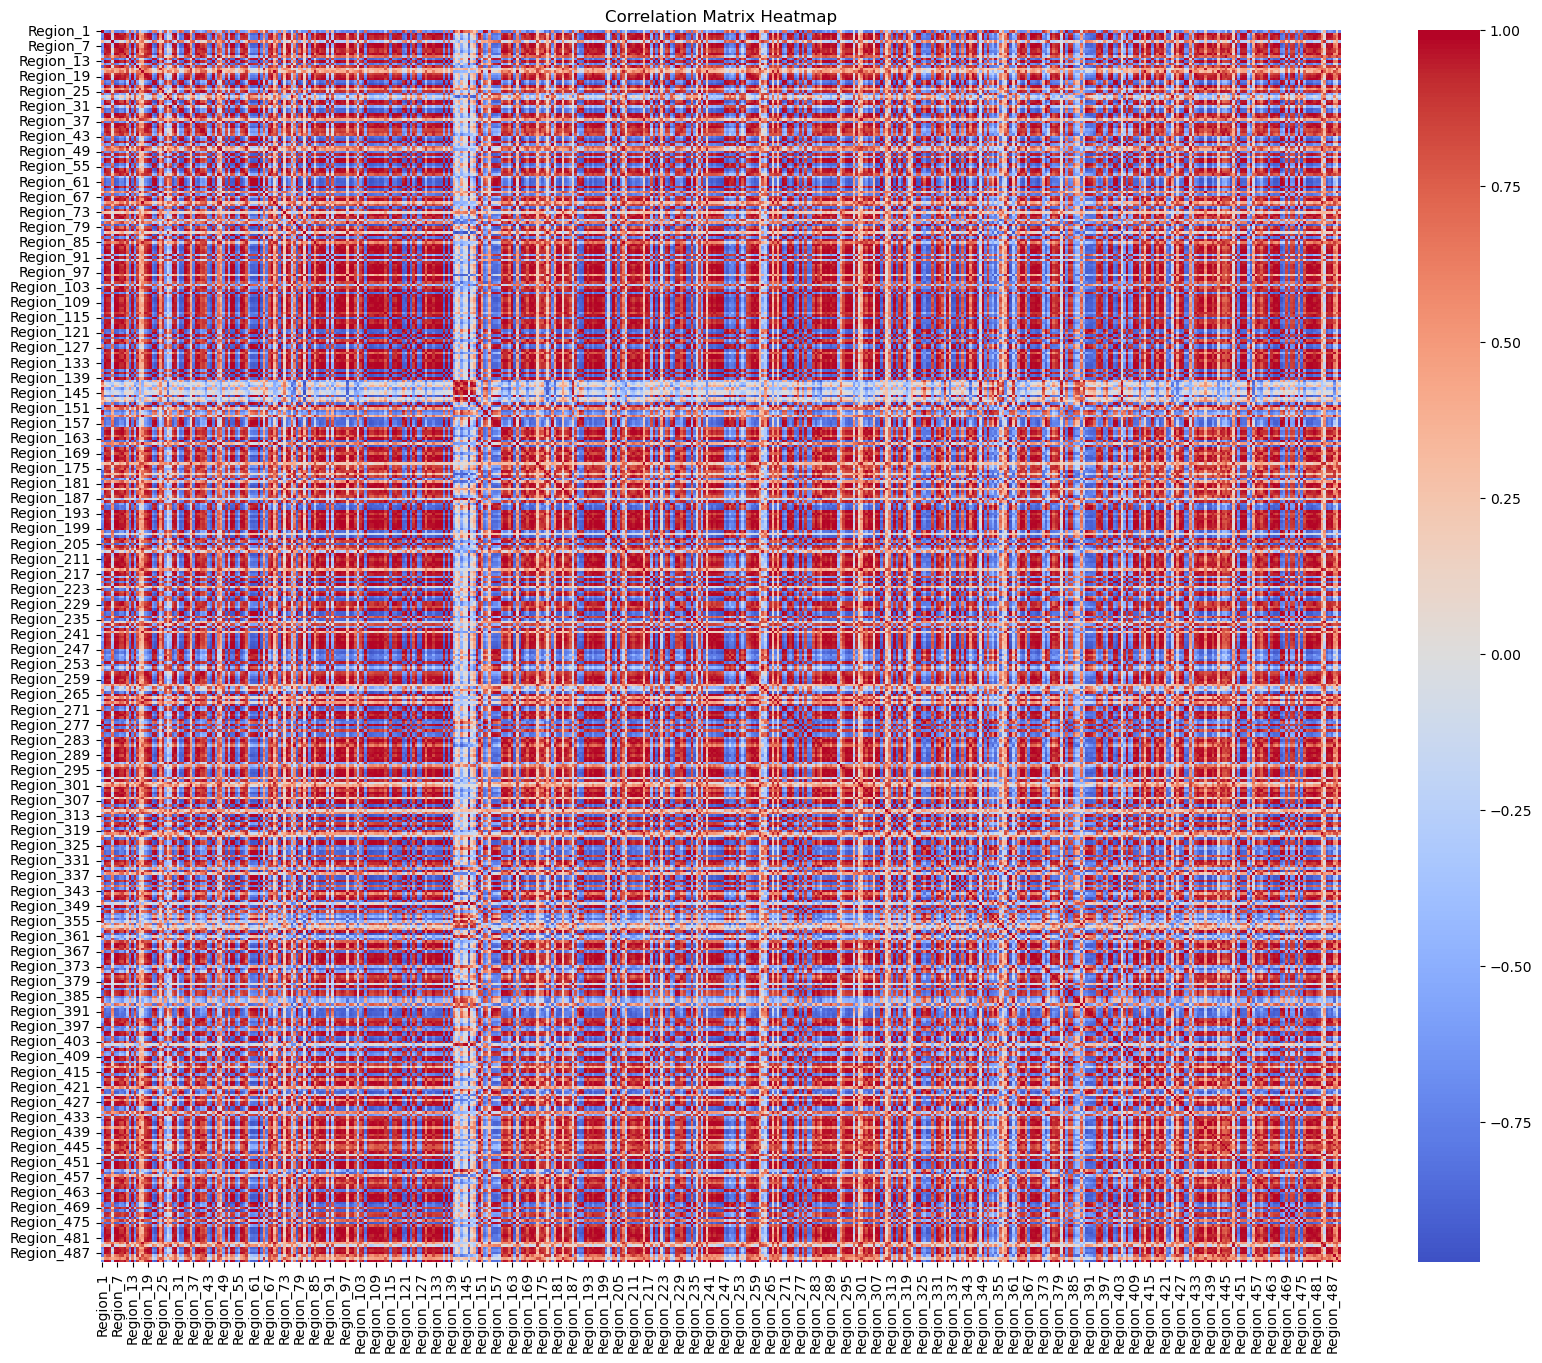

In [154]:
# 计算相关性矩阵
corr_matrix = data.corr()

# 绘制热力图
plt.figure(figsize=(20, 16))  # 设置图形大小
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [143]:
np.argsort(mean_res.std(axis = 1))

array([200, 172, 305,  72, 292, 173, 297,  30, 221, 331, 488, 340,  68,
       265, 299, 229,  27, 423, 267, 311,  66, 239,  84,  47,  16, 310,
       319, 412, 260, 300, 164,  41, 357, 335, 293, 338, 235, 441, 214,
       430, 473, 374, 182,  10, 420,  35, 482, 362, 344, 153, 150, 365,
        46,  15, 468, 403, 379, 206, 455,  91, 447, 183, 175, 377, 425,
       112, 187, 443, 483,  64, 207, 251, 278,  76,   4, 487,  39, 236,
       320, 128, 445, 233,  57, 330, 444, 255, 315, 380, 470, 458,  69,
       101,  40, 102, 411, 213,  37, 457,  24, 417, 185, 431, 302, 459,
       205,  34, 203,  14, 176,  88, 284,  80, 383,  17,   7, 400, 152,
       332, 350, 161, 301, 253, 475, 343, 393, 448, 261, 328, 371, 356,
        89, 262,  56, 227, 179, 174, 178, 471, 439, 361,  26,  75, 291,
       394, 158,  50, 115, 349, 298,  29,   2, 131, 485, 368, 436, 256,
         8, 304,   3, 194, 210,  74, 168, 228, 237,  97, 407, 406, 223,
       283, 123, 318, 376, 216, 427, 378, 442,   0, 433,  18, 47

In [63]:
# responses = responses.mean(axis = 0)

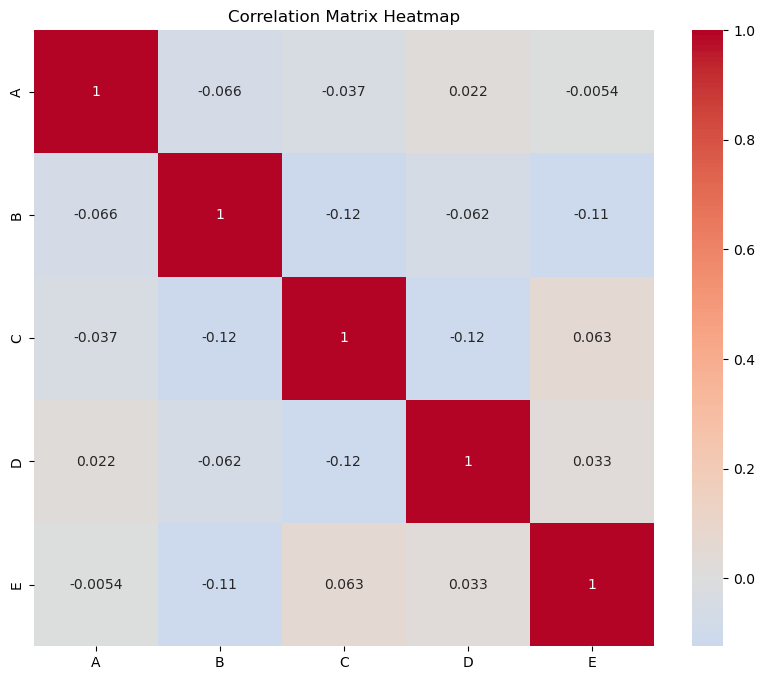

In [144]:
start_date = '2023-04-01 00:00:00'
target_time = '2024-03-01 00:00:00'

# 将日期字符串转换为 datetime 对象
start_date = pd.to_datetime(start_date)
target_time = pd.to_datetime(target_time)

# 计算时间差
time_difference = target_time - start_date

# 将时间差转换为小时数
time_idx = int(time_difference.total_seconds() / 3600)
print(time_idx)

device = 'cuda:0'

responses = np.zeros((490, 24, len(treats)))

with torch.no_grad():
        
    indice, x, y, _, _, adj = data[time_idx]
    mask = None
    causal_model.eval()

    indice = torch.LongTensor(indice)
    t = torch.LongTensor([calculate_week_hour(i.numpy().tolist()) for i in indice[:input_window]])
    #t = indice[:self.args.input_window] % self.args.tim_num  # 获取时间步
    t = t.unsqueeze(1).expand(-1, x.shape[1])  # 扩展时间步的维度

    x = x.unsqueeze(0).unsqueeze(-1).to(device).float()
    y = y.unsqueeze(0).to(device)
    t = t.unsqueeze(0).to(device)
    adj = adj.unsqueeze(0).to(device)
    for i, label in enumerate(selected):
        for idx in selected[label]:
            treat = treats[idx//490][1][0, :, idx % 490, :].unsqueeze(1).repeat(1, 490, 1).unsqueeze(0).to(device)
            y_pre, _, _, _ = causal_model(x, t, treat, adj)
            for j in range(output_window):  
#                 y_pred = torch.flatten(scaler.inverse_transform(y_pre[:, j].detach().cpu().unsqueeze(0))).detach().numpy()
#                 y_true = torch.flatten(scaler.inverse_transform(y[:, j].detach().cpu().squeeze())).detach().numpy()
                y_pred = torch.flatten(y_pre[:, j].detach().cpu().unsqueeze(0)).detach().numpy()
                y_true = torch.flatten(y[:, j].detach().cpu().squeeze()).detach().numpy()
                responses[:, j, i] += y_pred - y_true

In [181]:
len(treats)

48